In [1]:
### imports

# external modules
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import importlib
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model, Sequential, load_model
import importlib
from sklearn.preprocessing import StandardScaler

# local modules
sys.path.append('../utils')
import csv_utils as csvu
import json_utils as jsonu
import dataframe_utils as dfu
import hist_utils as hu
import autoencoder_utils as aeu
import plot_utils as pu
import generate_data_utils as gdu
import refruns_utils as rru
importlib.reload(csvu)
importlib.reload(jsonu)
importlib.reload(dfu)
importlib.reload(hu)
importlib.reload(aeu)
importlib.reload(pu)
importlib.reload(gdu)
importlib.reload(rru)
sys.path.append('../src')
sys.path.append('../src/classifiers')
sys.path.append('../src/cloudfitters')
import HistStruct
importlib.reload(HistStruct)
import SubHistStruct
importlib.reload(SubHistStruct)
import FlexiStruct
importlib.reload(FlexiStruct)
import DataLoader
importlib.reload(DataLoader)
import AutoEncoder
importlib.reload(AutoEncoder)
import SeminormalFitter
import GaussianKdeFitter
import HyperRectangleFitter
importlib.reload(SeminormalFitter)
importlib.reload(GaussianKdeFitter)
importlib.reload(HyperRectangleFitter)

2022-07-14 18:42:37.977888: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc8-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc8-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc8-opt/jre/lib/amd64:/cvmfs/sft.

<module 'HyperRectangleFitter' from '/eos/home-i01/k/khowey/SWAN_projects/ML4DQMDC-PixelAE/KH-AutoencoderTest/../src/cloudfitters/HyperRectangleFitter.py'>

In [2]:
### Speed Controls and Run Mode

# Disables all plots for large datasets where speed is more important
createPlots = False

# Control for the notebook - turn off user-friendly mode to enable faster runtimes
userfriendly = True

In [3]:
### Evaluation Parameters

# Select the bias towards recall against precision, treated as a factor (so < 1 biases towards precision, 1 is equal importance, and > 1 biases towards recall)
wpBiasFactor = 2
fmBiasFactor = 2

In [4]:
### Defining bad runs
badruns = {'2017B':
                [
                    297048,
                    297282,
                    297283,
                    297284,
                    297287,
                    297288,
                    297289,
                    299316,
                    299317,
                    299318,
                    299324,
                    299326,
                    301086,
                    301086,
                    303948,
                    297047, #close but, true bad for all 8
                    297169, #true bad for all 8
                    297211, #Reconstructs well
                    299325, #Reconstructs well
                    297664, #true bad for all 8
                    299317, #true bad for all 8
                    297169, #true bad for all 8
                    297502
                ],
             '2017C':[
                  300781, # bad for tracking (pixels were excluded.
                  300079, # is bad for strips and then also for tracking
                  302029, # Poor detector elements for strips - Should be mildly anomalous, but technically good 
                  300576, # Poor detector elements for strips - Should be mildly anomalous, but technically good
                  300574, # Poor detector elements for strips - Should be mildly anomalous, but technically good
                  300282, # Poor detector elements for strips - Should be mildly anomalous, but technically good
                  301912, # Half bad for pixels (lost HV or readout card)  
                  301086, # Half bad for pixels (lost HV or readout card)  
                  300283, # Half bad for pixels (lost HV or readout card) 
                  300282, # Half bad for pixels (lost HV or readout card) 
                  300281, # Half bad for pixels (lost HV or readout card) 
                  300239, # Half bad for pixels (lost HV or readout card)
                  301394, # Marginal for pixels
                  301183, # Marginal for pixels
                  300398, # Marginal for pixels
                  300389, # Marginal for pixels
                  300365  # Marginal for pixels
             ],
             '2017E':[
                 304740, # Bad for pixels and tracking - holes in PXLayer 1
                 304776, # Bad for pixels and tracking - holes in PXLayer 1
                 304506, # Portcard problem for pixels
                 304507, # Portcard problem for pixels 
                 303989, # Bad for pixels, power supply died
                 303824  # Partly bad for strips due to a test
             ],
             '2017F':[
                 306422, # Partly bad for strips - 2 data readouts failed 
                 306423, # Partly bad for strips - 2 data readouts failed
                 306425, # Partly bad for strips - 2 data readouts failed
                 305440, # Partly bad for strips - 1 data readout failed
                 305441, # Partly bad for strips - 1 data readout failed
                 305249, # Bad for pixels - half of disk failed 
                 305250, # Bad for pixels - half of disk failed
                 305064, # Marginal for pixels - some readout failed
             ],
            '2018': # needs to be re-checked, not guaranteed to be fully correct or representative.
                [
                317479,
                317480,
                317481,
                317482,
                319847
                ]}


In [12]:
### Select a reference run and get data
rundict = jsonu.loadjson('../jsons/CertHelperRefRuns.json')

# Select run numbers to get the references for
runNums = [303824, 306422]
refRuns = []
eras = []
years = []
dataDict = {}
badrunsls = {}
trainrunsls = {}
goodrunsls = {}
for runNum in runNums:
    runls = {}
    for run in rundict:
        if run['run_number'] == runNum:
            runls.update(run)
    if runls == {}:
        raise Exception('Run not found - ' + str(runNum))
    
    year = runls['dataset'][11:15]
    if year not in years: years.append(year)
    era = runls['dataset'][15]
    if era not in eras: eras.append(era)
    ref_run = runls['reference_run_number']
    
    # Don't need duplicates
    if ref_run in refRuns:
        continue
    refRuns.append(ref_run)
    
    # Get the runs associated with found reference
    outputRuns = {}
    outputBad = {}
    for run in rundict:
        tempRef = run['reference_run_number']
        if tempRef == ref_run:
            runls = {}
            runls[str(run['run_number'])] = [[-1]]
            if run['run_number'] in badruns[year+era]:
                print('Found bad run :' + str(run))
                outputBad.update(runls)
            else:
                outputRuns.update(runls)
    
    # Perform structuring for compatibility with autoencoders
    dataDict[year + era] = outputRuns
    badrunsls[year + era] = outputBad
    trainrunsls[year + era] = {}
    goodrunsls[year + era] = {}
    
    # Select training and testing set
    for i,run in enumerate(dataDict[year + era]):
        if i > 5 and i < 11:
            goodrunsls[year + era][str(run)] = [[-1]]
        else:
            trainrunsls[year + era][str(run)] = [[-1]]

if len(years) != 1: raise Exception('Year of length 0 or >1 unimplemented!')

Found bad run :{'run_number': 303824, 'run_reconstruction_type': 'rerecoul', 'reference_run_number': 304158, 'reference_run_reconstruction_type': 'rerecoul', 'dataset': '/ReReco/Run2017E_UL2019/DQM'}
Found bad run :{'run_number': 303989, 'run_reconstruction_type': 'rerecoul', 'reference_run_number': 304158, 'reference_run_reconstruction_type': 'rerecoul', 'dataset': '/ReReco/Run2017E_UL2019/DQM'}
Found bad run :{'run_number': 304740, 'run_reconstruction_type': 'rerecoul', 'reference_run_number': 304158, 'reference_run_reconstruction_type': 'rerecoul', 'dataset': '/ReReco/Run2017E_UL2019/DQM'}
Found bad run :{'run_number': 305250, 'run_reconstruction_type': 'rerecoul', 'reference_run_number': 306459, 'reference_run_reconstruction_type': 'rerecoul', 'dataset': '/ReReco/Run2017F_UL2019/DQM'}
Found bad run :{'run_number': 306422, 'run_reconstruction_type': 'rerecoul', 'reference_run_number': 306459, 'reference_run_reconstruction_type': 'rerecoul', 'dataset': '/ReReco/Run2017F_UL2019/DQM'}


In [13]:
### Data Controls and Selection - 1D Autoncoder

# The directory data is located in
datadir = {}
for era in eras:
    datadir[year + era] = '../data/' + year + era + '/'

# Create a list of histograms to include
# Pair histograms to be combined on the same line
histnames = [['chargeInner_PXLayer_1', 'chargeInner_PXLayer_2', 'chargeInner_PXLayer_3', 'chargeInner_PXLayer_4', 'chargeOuter_PXLayer_1', 'chargeOuter_PXLayer_2', 'chargeOuter_PXLayer_3', 'chargeOuter_PXLayer_4', 'adc_PXLayer_1', 'adc_PXLayer_2', 'adc_PXLayer_3', 'adc_PXLayer_4', 'size_PXLayer_1', 'size_PXLayer_2', 'size_PXLayer_3', 'size_PXLayer_4'], ['charge_PXDisk_+1', 'charge_PXDisk_+2', 'charge_PXDisk_+3', 'adc_PXDisk_+1', 'adc_PXDisk_+2', 'adc_PXDisk_+3', 'size_PXDisk_+1', 'size_PXDisk_+2', 'size_PXDisk_+3'], ['charge_PXDisk_-1', 'charge_PXDisk_-2', 'charge_PXDisk_-3', 'adc_PXDisk_-1', 'adc_PXDisk_-2', 'adc_PXDisk_-3', 'size_PXDisk_-1', 'size_PXDisk_-2', 'size_PXDisk_-3'], ['NormalizedHitResiduals_TIB__Layer__1', 'NormalizedHitResiduals_TIB__Layer__2', 'NormalizedHitResiduals_TIB__Layer__3', 'NormalizedHitResiduals_TIB__Layer__4', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__1', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__2', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__3', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__4'], ['NormalizedHitResiduals_TOB__Layer__1', 'NormalizedHitResiduals_TOB__Layer__2', 'NormalizedHitResiduals_TOB__Layer__3', 'NormalizedHitResiduals_TOB__Layer__4', 'NormalizedHitResiduals_TOB__Layer__5', 'NormalizedHitResiduals_TOB__Layer__6', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__1', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__2', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__3', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__4', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__5', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__6'], ['Summary_ClusterStoNCorr__OnTrack__TID__PLUS__wheel__1', 'Summary_ClusterStoNCorr__OnTrack__TID__PLUS__wheel__2', 'Summary_ClusterStoNCorr__OnTrack__TID__PLUS__wheel__3'], ['NormalizedHitResiduals_TID__wheel__1', 'NormalizedHitResiduals_TID__wheel__2', 'NormalizedHitResiduals_TID__wheel__3', 'Summary_ClusterStoNCorr__OnTrack__TID__MINUS__wheel__1', 'Summary_ClusterStoNCorr__OnTrack__TID__MINUS__wheel__2', 'Summary_ClusterStoNCorr__OnTrack__TID__MINUS__wheel__3'], ['Summary_ClusterStoNCorr__OnTrack__TEC__PLUS__wheel__1', 'Summary_ClusterStoNCorr__OnTrack__TEC__PLUS__wheel__2', 'Summary_ClusterStoNCorr__OnTrack__TEC__PLUS__wheel__3', 'Summary_ClusterStoNCorr__OnTrack__TEC__PLUS__wheel__4', 'Summary_ClusterStoNCorr__OnTrack__TEC__PLUS__wheel__5', 'Summary_ClusterStoNCorr__OnTrack__TEC__PLUS__wheel__6', 'Summary_ClusterStoNCorr__OnTrack__TEC__PLUS__wheel__7', 'Summary_ClusterStoNCorr__OnTrack__TEC__PLUS__wheel__8', 'Summary_ClusterStoNCorr__OnTrack__TEC__PLUS__wheel__9'], ['NormalizedHitResiduals_TEC__wheel__1', 'NormalizedHitResiduals_TEC__wheel__2', 'NormalizedHitResiduals_TEC__wheel__3', 'NormalizedHitResiduals_TEC__wheel__4', 'NormalizedHitResiduals_TEC__wheel__5', 'NormalizedHitResiduals_TEC__wheel__6', 'NormalizedHitResiduals_TEC__wheel__7', 'NormalizedHitResiduals_TEC__wheel__8', 'NormalizedHitResiduals_TEC__wheel__9', 'Summary_ClusterStoNCorr__OnTrack__TEC__MINUS__wheel__1', 'Summary_ClusterStoNCorr__OnTrack__TEC__MINUS__wheel__2', 'Summary_ClusterStoNCorr__OnTrack__TEC__MINUS__wheel__3', 'Summary_ClusterStoNCorr__OnTrack__TEC__MINUS__wheel__4', 'Summary_ClusterStoNCorr__OnTrack__TEC__MINUS__wheel__5', 'Summary_ClusterStoNCorr__OnTrack__TEC__MINUS__wheel__6', 'Summary_ClusterStoNCorr__OnTrack__TEC__MINUS__wheel__7', 'Summary_ClusterStoNCorr__OnTrack__TEC__MINUS__wheel__8', 'Summary_ClusterStoNCorr__OnTrack__TEC__MINUS__wheel__9'], ['NumberOfRecHitsPerTrack_lumiFlag_GenTk', 'Chi2oNDF_lumiFlag_GenTk', 'goodvtxNbr'], ['num_clusters_ontrack_PXBarrel', 'num_clusters_ontrack_PXForward']]

# Read new data or use previously saved data & should data be saved
readnew = True
save = False

In [14]:
### Define Run Properties - Combined Autoencoder
# in this cell all major run properties are going to be set,

# Set whether to train globally or locally or in a development/testing mode
training_mode = 'development'

In [15]:
### Model Controls and Selection - 1D Autoencoder

plotNames = 'Test'
name = plotNames+'plots'

# Choose whether to train a new model or load one
trainnew = True
savemodel = True
modelname = plotNames

In [16]:
### Define Training Mode Parameters - Combined Autoencoder
if training_mode == 'global':
    runsls_training = None # use none to not add a mask for training (can e.g. use DCS-bit on mask)
    runsls_good = None # use none to not add a mask for good runs (can e.g. use averages of training set)
    runsls_bad = badrunsls[year] # predefined bad runs
    print('selected runs/lumisections for training: all')
    
elif training_mode == 'local':
    # train locally on a small set of runs
    # - either on n runs preceding a chosen application run,
    # - or on the run associated as reference to the chosen application run.
    # - this only works for a single era
    
    available_runs = dfu.get_runs( dfu.select_dcson( csvu.read_csv('../data/DF'+year+era+'_'+histnames[0][0]+'.csv') ) )
    # Cherry picked really bad run
    run_application = 299316
    #run_application = 299317
    run_application_index = available_runs.index(run_application)
    # select training set
    usereference = False
    if usereference:
        run_reference = rru.get_reference_run( run_application, jsonfile='../utils/json_allRunsRefRuns.json' )
        if run_reference<0:
            raise Exception('no valid reference run has been defined for run {}'.format(run_application))
        runsls_training = jsonu.tuplelist_to_jsondict([(run_reference,[-1])])
    else:
        ntraining = 5
        offset = 0 # normal case: offset = 0 (just use 5 previous runs)
        
        # Selects the 5 previous runs for training
        runsls_training = jsonu.tuplelist_to_jsondict([(el,[-1]) for el in available_runs[run_application_index-ntraining-offset:run_application_index-offset]])
    #runsls_bad = badrunsls[year]
    #runsls_good = jsonu.tuplelist_to_jsondict([(run_application,[-1])])
    runsls_bad = jsonu.tuplelist_to_jsondict([(run_application,[-1])])
    runsls_good = runsls_training
    print('selected runs/lumisections for training: ')
    print(runsls_training)
    print('selected runs/lumisections as good test set:')
    print(runsls_good)
    print('selected runs/lumisections as bad test set:')
    print(runsls_bad)
        
elif training_mode == 'development':
    # train on a user-defined subset of runs
    
   # Select runs to be used in training from the user-defined list
    runsls_training = {}
    runsls_bad = {}
    runsls_good = {}
    for era in eras:
        runsls_training.update(trainrunsls[year + era])
        # Select bad runs to test on in the user-defined list
        runsls_bad.update(badrunsls[year + era])
        # Select good runs to test on in the user-defined list
        runsls_good.update(goodrunsls[year + era])
    
    print('selected runs/lumisections for training: ')
    print(runsls_training)
    print('selected runs/lumisections as good test set:')
    print(runsls_good)
    print('selected runs/lumisections as bad test set:')
    print(runsls_bad)

selected runs/lumisections for training: 
{'303819': [[-1]], '303999': [[-1]], '304119': [[-1]], '304120': [[-1]], '304197': [[-1]], '304505': [[-1]], '304449': [[-1]], '304452': [[-1]], '304508': [[-1]], '304625': [[-1]], '304655': [[-1]], '304737': [[-1]], '304778': [[-1]], '306459': [[-1]], '304196': [[-1]], '305310': [[-1]], '305040': [[-1]], '305043': [[-1]], '305185': [[-1]], '305204': [[-1]], '305234': [[-1]], '305376': [[-1]], '306042': [[-1]], '306051': [[-1]], '305406': [[-1]], '306122': [[-1]], '306134': [[-1]], '306137': [[-1]], '306154': [[-1]], '306170': [[-1]], '306417': [[-1]], '306432': [[-1]], '306456': [[-1]], '305516': [[-1]], '305586': [[-1]], '305588': [[-1]], '305590': [[-1]], '305809': [[-1]], '305832': [[-1]], '305840': [[-1]], '305898': [[-1]], '306029': [[-1]], '306037': [[-1]], '306095': [[-1]]}
selected runs/lumisections as good test set:
{'304198': [[-1]], '304199': [[-1]], '304209': [[-1]], '304333': [[-1]], '304446': [[-1]], '305247': [[-1]], '305313': [

In [18]:
### Data Import

# Create a new HistStruct from the data
if readnew:
    # Initializations
    dloader = DataLoader.DataLoader()
    histstruct = FlexiStruct.FlexiStruct()
    histstruct.reset_histlist(histnames)
    
    # Unpack histnames and add every histogram individually
    for era in eras:
        for histnamegroup in histnames:
            for histname in histnamegroup:
                print('Adding {}...'.format(histname))
                
                # Bring the histograms into memory from storage for later use
                filename = datadir[year+era] + 'DF' + year + era + '_' + histname + '.csv'
                df = dloader.get_dataframe_from_file( filename )
                
                # In case of local training, we can remove most of the histograms
                if( runsls_training is not None and runsls_good is not None and runsls_bad is not None ):
                    runsls_total = {k: v for d in (runsls_training, runsls_good, runsls_bad) for k, v in d.items()}
                    df = dfu.select_runsls( df, runsls_total )    
                
                df = dfu.rm_duplicates(df)
                # Store the data in the histstruct object managing this whole thing
                histstruct.add_dataframe( df, rebinningfactor = 1, standardbincount = 102 )
        print('Found {} histograms'.format(len(histstruct.runnbs)))

# Load a previously saved HistStruct
else:
    # Load histstruct from storage
    histstruct = SubHistStruct.SubHistStruct.load( 'histstruct_global_20220201.zip', verbose=False )
    nbadruns = len([name for name in list(histstruct.masks.keys()) if ('bad' in name and name!='bad')])
    
    print('loaded a histstruct with the following properties:')
    print(histstruct)
    # Count of bad runs, presumably for later use
    nbadruns = len([name for name in list(histstruct.masks.keys()) if 'bad' in name])
    
print('Created a histstruct with the following properties:')
print('- number of histogram types: {}'.format(len(histstruct.histnames)))
print('- number of lumisections: {}'.format(len(histstruct.lsnbs)))

Adding chargeInner_PXLayer_1...
Adding chargeInner_PXLayer_2...
Adding chargeInner_PXLayer_3...
Adding chargeInner_PXLayer_4...
Adding chargeOuter_PXLayer_1...
Adding chargeOuter_PXLayer_2...
Adding chargeOuter_PXLayer_3...
Adding chargeOuter_PXLayer_4...
Adding adc_PXLayer_1...
Adding adc_PXLayer_2...
Adding adc_PXLayer_3...
Adding adc_PXLayer_4...
Adding size_PXLayer_1...
Adding size_PXLayer_2...
Adding size_PXLayer_3...
Adding size_PXLayer_4...
Adding charge_PXDisk_+1...
Adding charge_PXDisk_+2...
Adding charge_PXDisk_+3...
Adding adc_PXDisk_+1...
Adding adc_PXDisk_+2...
Adding adc_PXDisk_+3...
Adding size_PXDisk_+1...
Adding size_PXDisk_+2...
Adding size_PXDisk_+3...
Adding charge_PXDisk_-1...
Adding charge_PXDisk_-2...
Adding charge_PXDisk_-3...
Adding adc_PXDisk_-1...
Adding adc_PXDisk_-2...
Adding adc_PXDisk_-3...
Adding size_PXDisk_-1...
Adding size_PXDisk_-2...
Adding size_PXDisk_-3...
Adding NormalizedHitResiduals_TIB__Layer__1...
Adding NormalizedHitResiduals_TIB__Layer__2..

Adding adc_PXDisk_-1...
Adding adc_PXDisk_-2...
Adding adc_PXDisk_-3...
Adding size_PXDisk_-1...
Adding size_PXDisk_-2...
Adding size_PXDisk_-3...
Adding NormalizedHitResiduals_TIB__Layer__1...
Adding NormalizedHitResiduals_TIB__Layer__2...
Adding NormalizedHitResiduals_TIB__Layer__3...
Adding NormalizedHitResiduals_TIB__Layer__4...
Adding Summary_ClusterStoNCorr__OnTrack__TIB__layer__1...
Adding Summary_ClusterStoNCorr__OnTrack__TIB__layer__2...
Adding Summary_ClusterStoNCorr__OnTrack__TIB__layer__3...
Adding Summary_ClusterStoNCorr__OnTrack__TIB__layer__4...
Adding NormalizedHitResiduals_TOB__Layer__1...
Adding NormalizedHitResiduals_TOB__Layer__2...
Adding NormalizedHitResiduals_TOB__Layer__3...
Adding NormalizedHitResiduals_TOB__Layer__4...
Adding NormalizedHitResiduals_TOB__Layer__5...
Adding NormalizedHitResiduals_TOB__Layer__6...
Adding Summary_ClusterStoNCorr__OnTrack__TOB__layer__1...
Adding Summary_ClusterStoNCorr__OnTrack__TOB__layer__2...
Adding Summary_ClusterStoNCorr__OnT

Adding NormalizedHitResiduals_TEC__wheel__8...
Adding NormalizedHitResiduals_TEC__wheel__9...
Adding Summary_ClusterStoNCorr__OnTrack__TEC__MINUS__wheel__1...
Adding Summary_ClusterStoNCorr__OnTrack__TEC__MINUS__wheel__2...
Adding Summary_ClusterStoNCorr__OnTrack__TEC__MINUS__wheel__3...
Adding Summary_ClusterStoNCorr__OnTrack__TEC__MINUS__wheel__4...
Adding Summary_ClusterStoNCorr__OnTrack__TEC__MINUS__wheel__5...
Adding Summary_ClusterStoNCorr__OnTrack__TEC__MINUS__wheel__6...
Adding Summary_ClusterStoNCorr__OnTrack__TEC__MINUS__wheel__7...
Adding Summary_ClusterStoNCorr__OnTrack__TEC__MINUS__wheel__8...
Adding Summary_ClusterStoNCorr__OnTrack__TEC__MINUS__wheel__9...
Adding NumberOfRecHitsPerTrack_lumiFlag_GenTk...
Adding Chi2oNDF_lumiFlag_GenTk...
Adding goodvtxNbr...
Adding num_clusters_ontrack_PXBarrel...
Adding num_clusters_ontrack_PXForward...
Found 25676 histograms
Created a histstruct with the following properties:
- number of histogram types: 95
- number of lumisections: 256

In [19]:
### Add Masks to Data

if readnew:
    histstruct.add_dcsonjson_mask( 'dcson' )
    histstruct.add_goldenjson_mask('golden' )
    histstruct.add_highstat_mask( 'highstat',entries_to_bins_ratio=0)
    histstruct.add_stat_mask( 'lowstat', max_entries_to_bins_ratio=0 )
    if runsls_training is not None: histstruct.add_json_mask( 'training', runsls_training )
    if runsls_good is not None: histstruct.add_json_mask( 'good', runsls_good )
        
    # Distinguishing bad runs
    nbadruns = 0
    if runsls_bad is not None:
        print(runsls_bad)
        histstruct.add_json_mask( 'bad', runsls_bad )
        
        # Special case for bad runs: add a mask per run (different bad runs have different characteristics)
        nbadruns = len(runsls_bad.keys())
        for i,badrun in enumerate(runsls_bad.keys()):
            histstruct.add_json_mask( 'bad{}'.format(i), {badrun:runsls_bad[badrun]} )
            
    if save:
        histstruct.save('test.pk1')
if userfriendly: print('Assigned masks: {}'.format(list(histstruct.masks.keys())))

{'303824': [[-1]], '303989': [[-1]], '304740': [[-1]], '305250': [[-1]], '306422': [[-1]], '305249': [[-1]]}
Assigned masks: ['dcson', 'golden', 'highstat', 'lowstat', 'training', 'good', 'bad', 'bad0', 'bad1', 'bad2', 'bad3', 'bad4', 'bad5']


In [20]:
### Plotting the input data for analysis

if((training_mode=='local' or training_mode == 'development') and createPlots):

    # training and application runs
    histstruct.plot_histograms( masknames=[['dcson','highstat','training'],['dcson','highstat','good']],
                                labellist = ['training','testing'],
                                colorlist = ['blue','green']
                              )
    
    # application run and bad test runs
    histstruct.plot_histograms( masknames=[['dcson','highstat','good'],['dcson','highstat','bad0']],
                                labellist = ['good','bad'],
                                colorlist = ['green','red']
                              )
    
elif( training_mode=='global' and createPlots):
    
    # bad test runs
    for i in [0,1,2,3,4,5,6]:
        histstruct.plot_histograms( masknames=[['dcson','highstat','good'],['dcson','highstat','bad{}'.format(i)]],
                                labellist = ['typical good histograms','bad'],
                                colorlist = ['blue','red'],
                                transparencylist = [0.01,1.]
                                    )

In [21]:
def define_concatamash_autoencoder(histstruct):
    
    histslist = []
    vallist = []
    autoencoders = []
    if trainnew:
        for i,histnamegroup in enumerate(histnames):
            
            train_normhist = np.array([hu.normalize(histstruct.get_histograms(
                histname = hname, masknames = ['dcson','highstat', 'training']), 
                                                 norm="l1", axis=1) 
                                       for hname in histnamegroup]).transpose((1,0,2))
            X_train, X_val = train_test_split(train_normhist, test_size=0.4, random_state=42)
            
            if userfriendly:
                print('\nNow Defining model {}/'.format(i + 1) 
                      + str(len(histnames)))
                print(' - Size of training set: {}'.format(X_train.shape))
            
            # Half the total bin count
            arch = 51 * len(histnamegroup)
            
            ## Model parameters
            print(X_train.shape)
            
            input_dim = X_train.shape[2] #num of predictor variables
            Input_layers=[Input(shape=input_dim) for i in range((X_train.shape[1]))]
            
            # Defining layers
            conc_layer = Concatenate()(Input_layers)
            encoder = Dense(arch * 2, activation="tanh")(conc_layer)
            #encoder = Dense(128, activation='relu')(encoder)
            #
            #encoder = Dense(32, activation='relu')(encoder)
            
            decoder = Dense(arch, activation="relu")(encoder)
            #decoder = Dense(256, activation="tanh")(decoder)
            
            Output_layers=[Dense(input_dim, activation="tanh")(decoder) for i in range(X_train.shape[1])]

            autoencoder = Model(inputs=Input_layers, outputs=Output_layers)
            autoencoder.summary()
            autoencoders.append(autoencoder)
            
            histslist.append(X_train)
            vallist.append(X_val)
     
        # Return the histograms stored 2-Dimensionally and the autoencoders corresponding
        return(histslist, vallist, autoencoders, train_normhist)
    return[_,_,_,_]

In [22]:
(histslist, vallist, autoencoders, train_normhist) = define_concatamash_autoencoder(histstruct)


Now Defining model 1/11
 - Size of training set: (11589, 16, 102)
(11589, 16, 102)


2022-07-14 19:00:25.981710: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc8-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc8-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc8-opt/jre/lib/amd64:/cvmfs/sft.cern.ch/lc

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 102)]        0                                            
______________________________________________________________________________________________


Now Defining model 2/11
 - Size of training set: (11589, 9, 102)
(11589, 9, 102)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 102)]        0                                            
__________


Now Defining model 4/11
 - Size of training set: (11589, 8, 102)
(11589, 8, 102)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_37 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_38 (InputLayer)           [(None, 102)]        0                                            
__________


Now Defining model 6/11
 - Size of training set: (11589, 3, 102)
(11589, 3, 102)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_55 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_56 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_57 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 306)          0           input_55[0][0]                   
          


Now Defining model 9/11
 - Size of training set: (11589, 18, 102)
(11589, 18, 102)
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_73 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_74 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_75 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_76 (InputLayer)           [(None, 102)]        0                                            
________


Now Defining model 10/11
 - Size of training set: (11589, 3, 102)
(11589, 3, 102)
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_91 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_92 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_93 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
concatenate_9 (Concatenate)     (None, 306)          0           input_91[0][0]                   
         

In [23]:
### Trains a combined autoencoder for every merge set
def train_concatamash_autoencoder(histstruct, histslist, vallist, autoencoders):
    
    # Iterate through the training data to train corresponding autoencoders
    for i in range(len(histslist)):
        
        if userfriendly: print('\nNow training model {}/'.format(i + 1) + str(len(histslist)))
        
        # Set variables to temporary values for better transparency
        X_train = histslist[i]
        X_val = vallist[i]
        autoencoder = autoencoders[i]
        
        
        ## Model parameters
        nb_epoch = 500
        batch_size = 500
        
        #checkpoint_filepath = 'checkpoint'
        #model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        #   filepath=checkpoint_filepath,
        #   save_weights_only=False,
        #   verbose=1,
        #   save_best_only=True,
        #   monitor='val_loss',
        #   mode='min')
        
        # Tell the model when to stop
        earlystop = EarlyStopping(monitor='val_loss',
            min_delta=1e-7,
            patience=20,
            verbose=1,
            mode='auto',
            baseline=None,
            restore_best_weights=True,
        )
        lr =0.001
        opt = keras.optimizers.Adam(learning_rate=lr)
        
        autoencoder.compile(loss='mse',
                            optimizer=opt)
        
        ## Train autoencoder
        train = autoencoder.fit(x=[X_train[:,i] for i in range(X_train.shape[1])],
                                y=[X_train[:,i] for i in range(X_train.shape[1])],
                            epochs=nb_epoch,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_data=([X_val[:,i] for i in range(X_val.shape[1])], [X_val[:,i] for i in range(X_val.shape[1])]),
                            verbose=1,
                            callbacks= [earlystop],    
                            )
        
        # Create a plot of the model
        
        tf.keras.utils.plot_model(
            autoencoder,
            to_file="models/modelConcatamash{}.png".format(i),
            show_shapes=True,
            show_dtype=False,
            show_layer_names=False,
            rankdir="TB")
        
        # Save classifier for evaluation
        classifier = AutoEncoder.AutoEncoder(model=autoencoder)
        histstruct.add_classifier(histnames[i][0], classifier)
        if savemodel:
            #autoencoder.save('../SavedModels/Concatamash' + '/AE' + str(j))
            pass

In [24]:
def load_concatamash_autoencoder():
    for i in range(len(histnames)):
        autoencoder = tf.keras.models.load_model('../SavedModels/Permutations/Job1/AE{}'.format(i))
        classifier = AutoEncoder.AutoEncoder(model=autoencoder)
        histstruct.add_classifier(histnames[i][0], classifier)

In [25]:
start = time.perf_counter()
if trainnew: train_concatamash_autoencoder(histstruct, histslist, vallist, autoencoders)
else: load_concatamash_autoencoder()
stop = time.perf_counter()
print(stop - start)


Now training model 1/11


2022-07-14 19:00:34.039357: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-14 19:00:34.043262: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2900000000 Hz


Epoch 1/500
24/24 [==============================] - 6s 122ms/step - loss: 0.0058 - dense_2_loss: 2.0778e-04 - dense_3_loss: 2.3934e-04 - dense_4_loss: 2.3590e-04 - dense_5_loss: 2.3177e-04 - dense_6_loss: 2.0354e-04 - dense_7_loss: 2.3911e-04 - dense_8_loss: 2.2996e-04 - dense_9_loss: 2.2290e-04 - dense_10_loss: 2.9370e-04 - dense_11_loss: 2.4922e-04 - dense_12_loss: 2.5821e-04 - dense_13_loss: 2.9124e-04 - dense_14_loss: 5.9035e-04 - dense_15_loss: 6.2959e-04 - dense_16_loss: 8.0893e-04 - dense_17_loss: 8.9436e-04 - val_loss: 6.8225e-04 - val_dense_2_loss: 3.7321e-05 - val_dense_3_loss: 3.4442e-05 - val_dense_4_loss: 3.7042e-05 - val_dense_5_loss: 4.1014e-05 - val_dense_6_loss: 3.0929e-05 - val_dense_7_loss: 5.0531e-05 - val_dense_8_loss: 3.8529e-05 - val_dense_9_loss: 3.5910e-05 - val_dense_10_loss: 3.7649e-05 - val_dense_11_loss: 3.4176e-05 - val_dense_12_loss: 3.4529e-05 - val_dense_13_loss: 4.6051e-05 - val_dense_14_loss: 4.9913e-05 - val_dense_15_loss: 3.8710e-05 - val_dense_16_

Epoch 9/500
24/24 [==============================] - 2s 84ms/step - loss: 6.1847e-05 - dense_2_loss: 4.8758e-06 - dense_3_loss: 4.6150e-06 - dense_4_loss: 3.5125e-06 - dense_5_loss: 2.8468e-06 - dense_6_loss: 3.4121e-06 - dense_7_loss: 3.8843e-06 - dense_8_loss: 4.2790e-06 - dense_9_loss: 2.7380e-06 - dense_10_loss: 2.8821e-06 - dense_11_loss: 3.1909e-06 - dense_12_loss: 3.5083e-06 - dense_13_loss: 4.3069e-06 - dense_14_loss: 1.1528e-05 - dense_15_loss: 1.9977e-06 - dense_16_loss: 2.3404e-06 - dense_17_loss: 1.9298e-06 - val_loss: 4.7213e-05 - val_dense_2_loss: 3.7579e-06 - val_dense_3_loss: 3.2232e-06 - val_dense_4_loss: 2.2886e-06 - val_dense_5_loss: 2.1113e-06 - val_dense_6_loss: 2.5965e-06 - val_dense_7_loss: 2.6827e-06 - val_dense_8_loss: 3.0144e-06 - val_dense_9_loss: 2.0193e-06 - val_dense_10_loss: 1.9705e-06 - val_dense_11_loss: 2.3250e-06 - val_dense_12_loss: 3.0305e-06 - val_dense_13_loss: 3.7207e-06 - val_dense_14_loss: 9.8431e-06 - val_dense_15_loss: 1.4981e-06 - val_dense_

Epoch 17/500
24/24 [==============================] - 2s 88ms/step - loss: 2.4224e-05 - dense_2_loss: 2.3664e-06 - dense_3_loss: 1.1479e-06 - dense_4_loss: 1.0507e-06 - dense_5_loss: 1.0468e-06 - dense_6_loss: 1.5322e-06 - dense_7_loss: 1.1060e-06 - dense_8_loss: 1.0546e-06 - dense_9_loss: 1.0016e-06 - dense_10_loss: 1.7326e-06 - dense_11_loss: 9.9219e-07 - dense_12_loss: 2.2483e-06 - dense_13_loss: 3.0251e-06 - dense_14_loss: 3.3049e-06 - dense_15_loss: 9.1702e-07 - dense_16_loss: 9.0709e-07 - dense_17_loss: 7.9082e-07 - val_loss: 2.2554e-05 - val_dense_2_loss: 2.2573e-06 - val_dense_3_loss: 1.0890e-06 - val_dense_4_loss: 9.6247e-07 - val_dense_5_loss: 1.0089e-06 - val_dense_6_loss: 1.5137e-06 - val_dense_7_loss: 1.0271e-06 - val_dense_8_loss: 1.1011e-06 - val_dense_9_loss: 9.3385e-07 - val_dense_10_loss: 1.3101e-06 - val_dense_11_loss: 7.7683e-07 - val_dense_12_loss: 2.2190e-06 - val_dense_13_loss: 2.9118e-06 - val_dense_14_loss: 2.9982e-06 - val_dense_15_loss: 9.0108e-07 - val_dense

Epoch 25/500
24/24 [==============================] - 2s 87ms/step - loss: 3.4633e-05 - dense_2_loss: 2.9492e-06 - dense_3_loss: 2.0787e-06 - dense_4_loss: 1.7621e-06 - dense_5_loss: 1.8482e-06 - dense_6_loss: 2.0918e-06 - dense_7_loss: 2.0204e-06 - dense_8_loss: 1.9902e-06 - dense_9_loss: 1.6948e-06 - dense_10_loss: 2.4053e-06 - dense_11_loss: 1.8428e-06 - dense_12_loss: 2.9219e-06 - dense_13_loss: 3.4026e-06 - dense_14_loss: 2.9127e-06 - dense_15_loss: 1.6987e-06 - dense_16_loss: 1.6417e-06 - dense_17_loss: 1.3724e-06 - val_loss: 4.6938e-05 - val_dense_2_loss: 3.6142e-06 - val_dense_3_loss: 2.6700e-06 - val_dense_4_loss: 2.4624e-06 - val_dense_5_loss: 2.4287e-06 - val_dense_6_loss: 3.5832e-06 - val_dense_7_loss: 2.5137e-06 - val_dense_8_loss: 2.7835e-06 - val_dense_9_loss: 2.5860e-06 - val_dense_10_loss: 3.2868e-06 - val_dense_11_loss: 2.3512e-06 - val_dense_12_loss: 3.3420e-06 - val_dense_13_loss: 4.1728e-06 - val_dense_14_loss: 3.5818e-06 - val_dense_15_loss: 2.1379e-06 - val_dense

Epoch 33/500
24/24 [==============================] - 2s 74ms/step - loss: 2.5883e-05 - dense_2_loss: 2.2511e-06 - dense_3_loss: 1.5452e-06 - dense_4_loss: 1.3843e-06 - dense_5_loss: 1.4528e-06 - dense_6_loss: 1.6973e-06 - dense_7_loss: 1.4439e-06 - dense_8_loss: 1.4558e-06 - dense_9_loss: 1.3575e-06 - dense_10_loss: 1.8910e-06 - dense_11_loss: 1.1855e-06 - dense_12_loss: 1.9675e-06 - dense_13_loss: 2.5820e-06 - dense_14_loss: 2.2036e-06 - dense_15_loss: 1.3121e-06 - dense_16_loss: 1.1695e-06 - dense_17_loss: 9.8390e-07 - val_loss: 2.5396e-05 - val_dense_2_loss: 2.1580e-06 - val_dense_3_loss: 1.5205e-06 - val_dense_4_loss: 1.5077e-06 - val_dense_5_loss: 1.4251e-06 - val_dense_6_loss: 1.6278e-06 - val_dense_7_loss: 1.5234e-06 - val_dense_8_loss: 1.5629e-06 - val_dense_9_loss: 1.4628e-06 - val_dense_10_loss: 1.4249e-06 - val_dense_11_loss: 1.1261e-06 - val_dense_12_loss: 2.0959e-06 - val_dense_13_loss: 2.4826e-06 - val_dense_14_loss: 2.2649e-06 - val_dense_15_loss: 1.1896e-06 - val_dense

Epoch 41/500
24/24 [==============================] - 2s 78ms/step - loss: 2.6253e-05 - dense_2_loss: 2.1508e-06 - dense_3_loss: 1.6291e-06 - dense_4_loss: 1.4190e-06 - dense_5_loss: 1.6622e-06 - dense_6_loss: 1.7872e-06 - dense_7_loss: 1.6590e-06 - dense_8_loss: 1.6211e-06 - dense_9_loss: 1.6600e-06 - dense_10_loss: 1.7873e-06 - dense_11_loss: 1.1687e-06 - dense_12_loss: 1.5475e-06 - dense_13_loss: 1.9423e-06 - dense_14_loss: 2.0946e-06 - dense_15_loss: 1.5469e-06 - dense_16_loss: 1.3418e-06 - dense_17_loss: 1.2358e-06 - val_loss: 2.7049e-05 - val_dense_2_loss: 2.2082e-06 - val_dense_3_loss: 1.8096e-06 - val_dense_4_loss: 1.5149e-06 - val_dense_5_loss: 1.6497e-06 - val_dense_6_loss: 1.6805e-06 - val_dense_7_loss: 1.8347e-06 - val_dense_8_loss: 1.6999e-06 - val_dense_9_loss: 1.5784e-06 - val_dense_10_loss: 1.6197e-06 - val_dense_11_loss: 9.9709e-07 - val_dense_12_loss: 1.9117e-06 - val_dense_13_loss: 1.8300e-06 - val_dense_14_loss: 2.1024e-06 - val_dense_15_loss: 1.5515e-06 - val_dense

Epoch 49/500
24/24 [==============================] - 2s 94ms/step - loss: 1.3856e-05 - dense_2_loss: 1.3586e-06 - dense_3_loss: 9.9377e-07 - dense_4_loss: 9.0476e-07 - dense_5_loss: 8.9818e-07 - dense_6_loss: 1.0126e-06 - dense_7_loss: 9.9453e-07 - dense_8_loss: 9.2350e-07 - dense_9_loss: 8.6933e-07 - dense_10_loss: 8.9638e-07 - dense_11_loss: 4.4166e-07 - dense_12_loss: 5.8905e-07 - dense_13_loss: 7.9748e-07 - dense_14_loss: 1.2414e-06 - dense_15_loss: 7.2544e-07 - dense_16_loss: 6.1900e-07 - dense_17_loss: 5.9061e-07 - val_loss: 1.2528e-05 - val_dense_2_loss: 1.2516e-06 - val_dense_3_loss: 9.2137e-07 - val_dense_4_loss: 7.7645e-07 - val_dense_5_loss: 8.2266e-07 - val_dense_6_loss: 9.1318e-07 - val_dense_7_loss: 8.3958e-07 - val_dense_8_loss: 9.1204e-07 - val_dense_9_loss: 8.0780e-07 - val_dense_10_loss: 7.2224e-07 - val_dense_11_loss: 3.2585e-07 - val_dense_12_loss: 5.2066e-07 - val_dense_13_loss: 7.1560e-07 - val_dense_14_loss: 1.1795e-06 - val_dense_15_loss: 7.2738e-07 - val_dense

Epoch 57/500
24/24 [==============================] - 2s 80ms/step - loss: 2.5776e-05 - dense_2_loss: 2.0926e-06 - dense_3_loss: 1.6821e-06 - dense_4_loss: 1.6968e-06 - dense_5_loss: 1.6482e-06 - dense_6_loss: 1.7357e-06 - dense_7_loss: 1.7256e-06 - dense_8_loss: 1.6978e-06 - dense_9_loss: 1.5893e-06 - dense_10_loss: 1.5517e-06 - dense_11_loss: 1.1487e-06 - dense_12_loss: 1.5014e-06 - dense_13_loss: 1.5482e-06 - dense_14_loss: 1.9180e-06 - dense_15_loss: 1.5033e-06 - dense_16_loss: 1.3262e-06 - dense_17_loss: 1.4098e-06 - val_loss: 2.1689e-05 - val_dense_2_loss: 1.6071e-06 - val_dense_3_loss: 1.4230e-06 - val_dense_4_loss: 1.3874e-06 - val_dense_5_loss: 1.6247e-06 - val_dense_6_loss: 1.5908e-06 - val_dense_7_loss: 1.4040e-06 - val_dense_8_loss: 1.5764e-06 - val_dense_9_loss: 1.5501e-06 - val_dense_10_loss: 1.3380e-06 - val_dense_11_loss: 8.3430e-07 - val_dense_12_loss: 1.0671e-06 - val_dense_13_loss: 1.2400e-06 - val_dense_14_loss: 1.3922e-06 - val_dense_15_loss: 1.2725e-06 - val_dense

Epoch 65/500
24/24 [==============================] - 2s 72ms/step - loss: 1.9412e-05 - dense_2_loss: 1.6552e-06 - dense_3_loss: 1.2901e-06 - dense_4_loss: 1.2774e-06 - dense_5_loss: 1.2819e-06 - dense_6_loss: 1.3641e-06 - dense_7_loss: 1.3048e-06 - dense_8_loss: 1.3045e-06 - dense_9_loss: 1.3398e-06 - dense_10_loss: 1.0513e-06 - dense_11_loss: 7.3335e-07 - dense_12_loss: 9.6223e-07 - dense_13_loss: 1.1330e-06 - dense_14_loss: 1.4824e-06 - dense_15_loss: 1.0698e-06 - dense_16_loss: 1.1272e-06 - dense_17_loss: 1.0347e-06 - val_loss: 1.2005e-05 - val_dense_2_loss: 1.0959e-06 - val_dense_3_loss: 9.0355e-07 - val_dense_4_loss: 8.1821e-07 - val_dense_5_loss: 8.5440e-07 - val_dense_6_loss: 8.4088e-07 - val_dense_7_loss: 8.0217e-07 - val_dense_8_loss: 8.7623e-07 - val_dense_9_loss: 8.0309e-07 - val_dense_10_loss: 6.1581e-07 - val_dense_11_loss: 3.5728e-07 - val_dense_12_loss: 5.1164e-07 - val_dense_13_loss: 6.5279e-07 - val_dense_14_loss: 9.7975e-07 - val_dense_15_loss: 7.5940e-07 - val_dense

Epoch 73/500
24/24 [==============================] - 2s 71ms/step - loss: 2.7381e-05 - dense_2_loss: 2.0193e-06 - dense_3_loss: 1.8286e-06 - dense_4_loss: 1.8975e-06 - dense_5_loss: 1.6870e-06 - dense_6_loss: 1.7518e-06 - dense_7_loss: 1.9321e-06 - dense_8_loss: 2.0830e-06 - dense_9_loss: 1.9044e-06 - dense_10_loss: 1.5261e-06 - dense_11_loss: 1.1778e-06 - dense_12_loss: 1.3147e-06 - dense_13_loss: 1.6476e-06 - dense_14_loss: 1.8406e-06 - dense_15_loss: 1.7554e-06 - dense_16_loss: 1.4603e-06 - dense_17_loss: 1.5550e-06 - val_loss: 1.5928e-05 - val_dense_2_loss: 1.1953e-06 - val_dense_3_loss: 1.1363e-06 - val_dense_4_loss: 1.1159e-06 - val_dense_5_loss: 1.0866e-06 - val_dense_6_loss: 1.0596e-06 - val_dense_7_loss: 1.0203e-06 - val_dense_8_loss: 1.1889e-06 - val_dense_9_loss: 1.0818e-06 - val_dense_10_loss: 8.6037e-07 - val_dense_11_loss: 5.5391e-07 - val_dense_12_loss: 8.1185e-07 - val_dense_13_loss: 9.2484e-07 - val_dense_14_loss: 1.2252e-06 - val_dense_15_loss: 1.0235e-06 - val_dense

Epoch 81/500
24/24 [==============================] - 2s 71ms/step - loss: 2.0576e-05 - dense_2_loss: 1.4153e-06 - dense_3_loss: 1.4099e-06 - dense_4_loss: 1.4575e-06 - dense_5_loss: 1.3841e-06 - dense_6_loss: 1.3460e-06 - dense_7_loss: 1.4582e-06 - dense_8_loss: 1.4306e-06 - dense_9_loss: 1.4260e-06 - dense_10_loss: 1.0612e-06 - dense_11_loss: 9.0029e-07 - dense_12_loss: 9.6137e-07 - dense_13_loss: 1.2703e-06 - dense_14_loss: 1.5206e-06 - dense_15_loss: 1.3353e-06 - dense_16_loss: 1.1274e-06 - dense_17_loss: 1.0721e-06 - val_loss: 1.4901e-05 - val_dense_2_loss: 1.0918e-06 - val_dense_3_loss: 1.0734e-06 - val_dense_4_loss: 1.0056e-06 - val_dense_5_loss: 1.0674e-06 - val_dense_6_loss: 9.6443e-07 - val_dense_7_loss: 1.0479e-06 - val_dense_8_loss: 1.1747e-06 - val_dense_9_loss: 9.8702e-07 - val_dense_10_loss: 7.1710e-07 - val_dense_11_loss: 5.2395e-07 - val_dense_12_loss: 7.7423e-07 - val_dense_13_loss: 8.2572e-07 - val_dense_14_loss: 1.1927e-06 - val_dense_15_loss: 8.9817e-07 - val_dense

Epoch 89/500
24/24 [==============================] - 2s 71ms/step - loss: 2.7521e-05 - dense_2_loss: 1.8631e-06 - dense_3_loss: 1.7122e-06 - dense_4_loss: 1.6935e-06 - dense_5_loss: 1.5859e-06 - dense_6_loss: 1.6254e-06 - dense_7_loss: 1.8157e-06 - dense_8_loss: 1.7664e-06 - dense_9_loss: 1.6774e-06 - dense_10_loss: 1.4561e-06 - dense_11_loss: 1.2568e-06 - dense_12_loss: 1.3785e-06 - dense_13_loss: 1.6310e-06 - dense_14_loss: 2.0035e-06 - dense_15_loss: 1.9436e-06 - dense_16_loss: 2.0535e-06 - dense_17_loss: 2.0585e-06 - val_loss: 1.2515e-05 - val_dense_2_loss: 9.0357e-07 - val_dense_3_loss: 8.7679e-07 - val_dense_4_loss: 9.2014e-07 - val_dense_5_loss: 9.8470e-07 - val_dense_6_loss: 7.6928e-07 - val_dense_7_loss: 8.5847e-07 - val_dense_8_loss: 9.2617e-07 - val_dense_9_loss: 9.2975e-07 - val_dense_10_loss: 5.5159e-07 - val_dense_11_loss: 4.5700e-07 - val_dense_12_loss: 5.8717e-07 - val_dense_13_loss: 7.0531e-07 - val_dense_14_loss: 9.5902e-07 - val_dense_15_loss: 7.9332e-07 - val_dense

Epoch 97/500
24/24 [==============================] - 4s 184ms/step - loss: 9.5909e-06 - dense_2_loss: 6.2051e-07 - dense_3_loss: 6.9781e-07 - dense_4_loss: 6.9990e-07 - dense_5_loss: 7.2187e-07 - dense_6_loss: 6.6319e-07 - dense_7_loss: 7.2220e-07 - dense_8_loss: 7.1210e-07 - dense_9_loss: 7.4984e-07 - dense_10_loss: 3.9323e-07 - dense_11_loss: 3.1680e-07 - dense_12_loss: 4.0227e-07 - dense_13_loss: 5.5192e-07 - dense_14_loss: 7.3372e-07 - dense_15_loss: 6.4269e-07 - dense_16_loss: 4.5534e-07 - dense_17_loss: 5.0751e-07 - val_loss: 8.2777e-06 - val_dense_2_loss: 5.3416e-07 - val_dense_3_loss: 6.2267e-07 - val_dense_4_loss: 6.1688e-07 - val_dense_5_loss: 6.9952e-07 - val_dense_6_loss: 5.3929e-07 - val_dense_7_loss: 6.0734e-07 - val_dense_8_loss: 6.8971e-07 - val_dense_9_loss: 6.8245e-07 - val_dense_10_loss: 2.4981e-07 - val_dense_11_loss: 1.7411e-07 - val_dense_12_loss: 3.6431e-07 - val_dense_13_loss: 4.6802e-07 - val_dense_14_loss: 6.8004e-07 - val_dense_15_loss: 5.3739e-07 - val_dens

Epoch 105/500
24/24 [==============================] - 5s 192ms/step - loss: 9.6727e-06 - dense_2_loss: 6.6264e-07 - dense_3_loss: 6.9637e-07 - dense_4_loss: 7.0947e-07 - dense_5_loss: 7.6304e-07 - dense_6_loss: 6.4385e-07 - dense_7_loss: 7.2771e-07 - dense_8_loss: 7.0714e-07 - dense_9_loss: 7.4540e-07 - dense_10_loss: 3.7269e-07 - dense_11_loss: 2.8871e-07 - dense_12_loss: 4.6722e-07 - dense_13_loss: 5.3933e-07 - dense_14_loss: 7.2000e-07 - dense_15_loss: 6.1378e-07 - dense_16_loss: 4.8188e-07 - dense_17_loss: 5.3342e-07 - val_loss: 1.1696e-05 - val_dense_2_loss: 7.3856e-07 - val_dense_3_loss: 8.4800e-07 - val_dense_4_loss: 8.0503e-07 - val_dense_5_loss: 9.3853e-07 - val_dense_6_loss: 8.0416e-07 - val_dense_7_loss: 8.2769e-07 - val_dense_8_loss: 8.9380e-07 - val_dense_9_loss: 8.7165e-07 - val_dense_10_loss: 4.4314e-07 - val_dense_11_loss: 3.5452e-07 - val_dense_12_loss: 5.6944e-07 - val_dense_13_loss: 6.7108e-07 - val_dense_14_loss: 8.4302e-07 - val_dense_15_loss: 7.7282e-07 - val_den

Epoch 113/500
24/24 [==============================] - 5s 201ms/step - loss: 8.8391e-06 - dense_2_loss: 5.9315e-07 - dense_3_loss: 6.3118e-07 - dense_4_loss: 6.6583e-07 - dense_5_loss: 6.9902e-07 - dense_6_loss: 6.0370e-07 - dense_7_loss: 6.6372e-07 - dense_8_loss: 6.5130e-07 - dense_9_loss: 7.0866e-07 - dense_10_loss: 3.2135e-07 - dense_11_loss: 2.9530e-07 - dense_12_loss: 3.8858e-07 - dense_13_loss: 4.3990e-07 - dense_14_loss: 6.2850e-07 - dense_15_loss: 6.0860e-07 - dense_16_loss: 4.6246e-07 - dense_17_loss: 4.7789e-07 - val_loss: 8.3135e-06 - val_dense_2_loss: 5.5612e-07 - val_dense_3_loss: 5.9230e-07 - val_dense_4_loss: 6.1865e-07 - val_dense_5_loss: 7.4259e-07 - val_dense_6_loss: 5.2306e-07 - val_dense_7_loss: 6.3278e-07 - val_dense_8_loss: 7.0158e-07 - val_dense_9_loss: 7.1821e-07 - val_dense_10_loss: 2.6069e-07 - val_dense_11_loss: 2.1816e-07 - val_dense_12_loss: 3.3791e-07 - val_dense_13_loss: 3.5816e-07 - val_dense_14_loss: 6.0520e-07 - val_dense_15_loss: 5.6041e-07 - val_den

24/24 [==============================] - 3s 122ms/step - loss: 2.6370e-05 - dense_20_loss: 5.3562e-06 - dense_21_loss: 4.8537e-06 - dense_22_loss: 4.1721e-06 - dense_23_loss: 2.9800e-06 - dense_24_loss: 2.8007e-06 - dense_25_loss: 2.6544e-06 - dense_26_loss: 1.1067e-06 - dense_27_loss: 1.1921e-06 - dense_28_loss: 1.2542e-06 - val_loss: 2.4696e-05 - val_dense_20_loss: 5.3226e-06 - val_dense_21_loss: 4.6860e-06 - val_dense_22_loss: 4.2015e-06 - val_dense_23_loss: 2.3221e-06 - val_dense_24_loss: 2.1971e-06 - val_dense_25_loss: 2.3047e-06 - val_dense_26_loss: 1.2244e-06 - val_dense_27_loss: 1.0422e-06 - val_dense_28_loss: 1.3954e-06
Epoch 6/500
24/24 [==============================] - 2s 100ms/step - loss: 2.6126e-05 - dense_20_loss: 5.3016e-06 - dense_21_loss: 4.7884e-06 - dense_22_loss: 4.1343e-06 - dense_23_loss: 2.9450e-06 - dense_24_loss: 2.7663e-06 - dense_25_loss: 2.6394e-06 - dense_26_loss: 1.1044e-06 - dense_27_loss: 1.1858e-06 - dense_28_loss: 1.2605e-06 - val_loss: 2.4426e-05 - 

Epoch 18/500
24/24 [==============================] - 3s 148ms/step - loss: 2.6817e-05 - dense_20_loss: 4.0605e-06 - dense_21_loss: 3.7210e-06 - dense_22_loss: 3.5880e-06 - dense_23_loss: 2.9188e-06 - dense_24_loss: 2.8396e-06 - dense_25_loss: 2.7497e-06 - dense_26_loss: 2.2590e-06 - dense_27_loss: 2.1891e-06 - dense_28_loss: 2.4909e-06 - val_loss: 2.9220e-05 - val_dense_20_loss: 4.4638e-06 - val_dense_21_loss: 3.7499e-06 - val_dense_22_loss: 4.0874e-06 - val_dense_23_loss: 2.8479e-06 - val_dense_24_loss: 3.3288e-06 - val_dense_25_loss: 2.9887e-06 - val_dense_26_loss: 2.4144e-06 - val_dense_27_loss: 2.3502e-06 - val_dense_28_loss: 2.9886e-06
Epoch 19/500
24/24 [==============================] - 3s 123ms/step - loss: 2.0308e-05 - dense_20_loss: 2.9112e-06 - dense_21_loss: 2.8938e-06 - dense_22_loss: 2.7636e-06 - dense_23_loss: 2.2205e-06 - dense_24_loss: 2.2041e-06 - dense_25_loss: 2.0991e-06 - dense_26_loss: 1.6603e-06 - dense_27_loss: 1.6898e-06 - dense_28_loss: 1.8655e-06 - val_loss:

Epoch 31/500
24/24 [==============================] - 2s 79ms/step - loss: 1.2786e-05 - dense_20_loss: 1.4073e-06 - dense_21_loss: 1.6266e-06 - dense_22_loss: 1.7161e-06 - dense_23_loss: 1.2193e-06 - dense_24_loss: 1.3428e-06 - dense_25_loss: 1.0275e-06 - dense_26_loss: 1.4094e-06 - dense_27_loss: 1.5874e-06 - dense_28_loss: 1.4497e-06 - val_loss: 2.9291e-05 - val_dense_20_loss: 3.3634e-06 - val_dense_21_loss: 3.0908e-06 - val_dense_22_loss: 3.7104e-06 - val_dense_23_loss: 2.6693e-06 - val_dense_24_loss: 3.3846e-06 - val_dense_25_loss: 2.9795e-06 - val_dense_26_loss: 3.2436e-06 - val_dense_27_loss: 3.2611e-06 - val_dense_28_loss: 3.5883e-06
Epoch 32/500
24/24 [==============================] - 2s 104ms/step - loss: 1.5986e-05 - dense_20_loss: 1.7748e-06 - dense_21_loss: 1.9531e-06 - dense_22_loss: 2.0323e-06 - dense_23_loss: 1.5355e-06 - dense_24_loss: 1.7105e-06 - dense_25_loss: 1.3699e-06 - dense_26_loss: 1.7000e-06 - dense_27_loss: 1.9722e-06 - dense_28_loss: 1.9375e-06 - val_loss: 

Epoch 44/500
24/24 [==============================] - 2s 105ms/step - loss: 1.4558e-05 - dense_20_loss: 1.6239e-06 - dense_21_loss: 1.7827e-06 - dense_22_loss: 1.8049e-06 - dense_23_loss: 1.5172e-06 - dense_24_loss: 1.5304e-06 - dense_25_loss: 1.2278e-06 - dense_26_loss: 1.6397e-06 - dense_27_loss: 1.7722e-06 - dense_28_loss: 1.6596e-06 - val_loss: 8.7820e-06 - val_dense_20_loss: 9.7560e-07 - val_dense_21_loss: 1.0797e-06 - val_dense_22_loss: 1.2460e-06 - val_dense_23_loss: 7.6470e-07 - val_dense_24_loss: 9.4483e-07 - val_dense_25_loss: 5.9677e-07 - val_dense_26_loss: 1.0804e-06 - val_dense_27_loss: 9.3305e-07 - val_dense_28_loss: 1.1610e-06
Epoch 45/500
24/24 [==============================] - 2s 77ms/step - loss: 6.7780e-06 - dense_20_loss: 7.3680e-07 - dense_21_loss: 8.8818e-07 - dense_22_loss: 9.3938e-07 - dense_23_loss: 6.1559e-07 - dense_24_loss: 6.7681e-07 - dense_25_loss: 4.1726e-07 - dense_26_loss: 7.2890e-07 - dense_27_loss: 8.9975e-07 - dense_28_loss: 8.7533e-07 - val_loss: 

Epoch 57/500
24/24 [==============================] - 2s 82ms/step - loss: 7.1020e-06 - dense_20_loss: 7.7750e-07 - dense_21_loss: 8.9941e-07 - dense_22_loss: 9.7382e-07 - dense_23_loss: 6.3963e-07 - dense_24_loss: 6.9733e-07 - dense_25_loss: 4.7133e-07 - dense_26_loss: 7.8874e-07 - dense_27_loss: 9.3025e-07 - dense_28_loss: 9.2397e-07 - val_loss: 8.2617e-06 - val_dense_20_loss: 9.2406e-07 - val_dense_21_loss: 9.4250e-07 - val_dense_22_loss: 1.2447e-06 - val_dense_23_loss: 7.3563e-07 - val_dense_24_loss: 8.7998e-07 - val_dense_25_loss: 5.4225e-07 - val_dense_26_loss: 1.0168e-06 - val_dense_27_loss: 8.6701e-07 - val_dense_28_loss: 1.1088e-06
Epoch 58/500
24/24 [==============================] - 2s 91ms/step - loss: 1.3050e-05 - dense_20_loss: 1.3923e-06 - dense_21_loss: 1.6718e-06 - dense_22_loss: 1.7125e-06 - dense_23_loss: 1.3358e-06 - dense_24_loss: 1.4355e-06 - dense_25_loss: 1.0683e-06 - dense_26_loss: 1.4119e-06 - dense_27_loss: 1.5116e-06 - dense_28_loss: 1.5097e-06 - val_loss: 1

Epoch 70/500
24/24 [==============================] - 2s 83ms/step - loss: 1.1723e-05 - dense_20_loss: 1.3109e-06 - dense_21_loss: 1.4754e-06 - dense_22_loss: 1.5177e-06 - dense_23_loss: 1.1656e-06 - dense_24_loss: 1.1921e-06 - dense_25_loss: 9.4319e-07 - dense_26_loss: 1.2840e-06 - dense_27_loss: 1.4367e-06 - dense_28_loss: 1.3975e-06 - val_loss: 7.3791e-06 - val_dense_20_loss: 8.0664e-07 - val_dense_21_loss: 8.5115e-07 - val_dense_22_loss: 1.0930e-06 - val_dense_23_loss: 6.3728e-07 - val_dense_24_loss: 8.0350e-07 - val_dense_25_loss: 4.3891e-07 - val_dense_26_loss: 9.0084e-07 - val_dense_27_loss: 8.1094e-07 - val_dense_28_loss: 1.0369e-06
Epoch 71/500
24/24 [==============================] - 2s 92ms/step - loss: 6.7255e-06 - dense_20_loss: 7.3018e-07 - dense_21_loss: 8.7791e-07 - dense_22_loss: 9.2430e-07 - dense_23_loss: 6.1435e-07 - dense_24_loss: 6.7939e-07 - dense_25_loss: 4.2045e-07 - dense_26_loss: 7.1507e-07 - dense_27_loss: 9.0752e-07 - dense_28_loss: 8.5632e-07 - val_loss: 8

24/24 [==============================] - 2s 100ms/step - loss: 7.4577e-06 - dense_20_loss: 8.4263e-07 - dense_21_loss: 9.8637e-07 - dense_22_loss: 1.0084e-06 - dense_23_loss: 6.6568e-07 - dense_24_loss: 7.1612e-07 - dense_25_loss: 4.9776e-07 - dense_26_loss: 7.7801e-07 - dense_27_loss: 9.6724e-07 - dense_28_loss: 9.9553e-07 - val_loss: 6.5787e-06 - val_dense_20_loss: 7.4297e-07 - val_dense_21_loss: 7.8438e-07 - val_dense_22_loss: 1.0083e-06 - val_dense_23_loss: 5.2092e-07 - val_dense_24_loss: 6.7999e-07 - val_dense_25_loss: 3.6231e-07 - val_dense_26_loss: 8.0676e-07 - val_dense_27_loss: 7.1174e-07 - val_dense_28_loss: 9.6130e-07
Epoch 83/500
24/24 [==============================] - 2s 100ms/step - loss: 6.2880e-06 - dense_20_loss: 6.9186e-07 - dense_21_loss: 8.2736e-07 - dense_22_loss: 9.0778e-07 - dense_23_loss: 5.3941e-07 - dense_24_loss: 5.9560e-07 - dense_25_loss: 3.8118e-07 - dense_26_loss: 6.6696e-07 - dense_27_loss: 8.5696e-07 - dense_28_loss: 8.2089e-07 - val_loss: 7.5448e-06 -

24/24 [==============================] - 11s 153ms/step - loss: 0.0052 - dense_31_loss: 3.3460e-04 - dense_32_loss: 3.3733e-04 - dense_33_loss: 2.8852e-04 - dense_34_loss: 3.2778e-04 - dense_35_loss: 3.3749e-04 - dense_36_loss: 2.8702e-04 - dense_37_loss: 0.0010 - dense_38_loss: 0.0012 - dense_39_loss: 0.0011 - val_loss: 4.5681e-04 - val_dense_31_loss: 7.4574e-05 - val_dense_32_loss: 6.3426e-05 - val_dense_33_loss: 6.4695e-05 - val_dense_34_loss: 4.3945e-05 - val_dense_35_loss: 6.1921e-05 - val_dense_36_loss: 4.6137e-05 - val_dense_37_loss: 3.3801e-05 - val_dense_38_loss: 2.9740e-05 - val_dense_39_loss: 3.8575e-05
Epoch 2/500
24/24 [==============================] - 3s 112ms/step - loss: 2.0157e-04 - dense_31_loss: 3.0728e-05 - dense_32_loss: 2.8068e-05 - dense_33_loss: 2.5518e-05 - dense_34_loss: 2.5271e-05 - dense_35_loss: 2.7187e-05 - dense_36_loss: 2.1641e-05 - dense_37_loss: 1.5579e-05 - dense_38_loss: 1.2565e-05 - dense_39_loss: 1.5012e-05 - val_loss: 6.2961e-05 - val_dense_31_lo

Epoch 14/500
24/24 [==============================] - 3s 122ms/step - loss: 2.5469e-05 - dense_31_loss: 5.4113e-06 - dense_32_loss: 4.4215e-06 - dense_33_loss: 3.7882e-06 - dense_34_loss: 2.8885e-06 - dense_35_loss: 2.0046e-06 - dense_36_loss: 2.3008e-06 - dense_37_loss: 1.9197e-06 - dense_38_loss: 1.3058e-06 - dense_39_loss: 1.4288e-06 - val_loss: 2.3775e-05 - val_dense_31_loss: 5.0624e-06 - val_dense_32_loss: 4.3216e-06 - val_dense_33_loss: 3.6848e-06 - val_dense_34_loss: 2.5059e-06 - val_dense_35_loss: 1.9329e-06 - val_dense_36_loss: 1.8369e-06 - val_dense_37_loss: 1.8435e-06 - val_dense_38_loss: 1.2158e-06 - val_dense_39_loss: 1.3711e-06
Epoch 15/500
24/24 [==============================] - 3s 117ms/step - loss: 3.2324e-05 - dense_31_loss: 6.0233e-06 - dense_32_loss: 4.7693e-06 - dense_33_loss: 4.5234e-06 - dense_34_loss: 3.6204e-06 - dense_35_loss: 2.9499e-06 - dense_36_loss: 3.2848e-06 - dense_37_loss: 2.7350e-06 - dense_38_loss: 2.1931e-06 - dense_39_loss: 2.2248e-06 - val_loss:

Epoch 27/500
24/24 [==============================] - 3s 108ms/step - loss: 1.0611e-05 - dense_31_loss: 1.2415e-06 - dense_32_loss: 1.1688e-06 - dense_33_loss: 1.2590e-06 - dense_34_loss: 1.4129e-06 - dense_35_loss: 1.0017e-06 - dense_36_loss: 9.9339e-07 - dense_37_loss: 1.4120e-06 - dense_38_loss: 1.0225e-06 - dense_39_loss: 1.0994e-06 - val_loss: 2.4432e-05 - val_dense_31_loss: 2.5013e-06 - val_dense_32_loss: 2.7213e-06 - val_dense_33_loss: 2.5353e-06 - val_dense_34_loss: 2.9130e-06 - val_dense_35_loss: 2.3746e-06 - val_dense_36_loss: 2.6510e-06 - val_dense_37_loss: 3.0810e-06 - val_dense_38_loss: 3.0612e-06 - val_dense_39_loss: 2.5938e-06
Epoch 28/500
24/24 [==============================] - 2s 82ms/step - loss: 1.3888e-05 - dense_31_loss: 1.5468e-06 - dense_32_loss: 1.4892e-06 - dense_33_loss: 1.5918e-06 - dense_34_loss: 1.7648e-06 - dense_35_loss: 1.3404e-06 - dense_36_loss: 1.4087e-06 - dense_37_loss: 1.8458e-06 - dense_38_loss: 1.4720e-06 - dense_39_loss: 1.4281e-06 - val_loss: 

Epoch 40/500
24/24 [==============================] - 3s 136ms/step - loss: 9.0911e-06 - dense_31_loss: 1.1340e-06 - dense_32_loss: 9.8505e-07 - dense_33_loss: 1.2166e-06 - dense_34_loss: 1.1947e-06 - dense_35_loss: 7.5286e-07 - dense_36_loss: 6.5613e-07 - dense_37_loss: 1.1387e-06 - dense_38_loss: 9.3974e-07 - dense_39_loss: 1.0733e-06 - val_loss: 1.7893e-05 - val_dense_31_loss: 2.1462e-06 - val_dense_32_loss: 1.9208e-06 - val_dense_33_loss: 2.5777e-06 - val_dense_34_loss: 2.2523e-06 - val_dense_35_loss: 1.4552e-06 - val_dense_36_loss: 1.6558e-06 - val_dense_37_loss: 2.0664e-06 - val_dense_38_loss: 1.7702e-06 - val_dense_39_loss: 2.0481e-06
Epoch 41/500
24/24 [==============================] - 3s 108ms/step - loss: 1.1524e-05 - dense_31_loss: 1.3951e-06 - dense_32_loss: 1.2685e-06 - dense_33_loss: 1.4831e-06 - dense_34_loss: 1.5193e-06 - dense_35_loss: 1.0559e-06 - dense_36_loss: 8.4698e-07 - dense_37_loss: 1.4344e-06 - dense_38_loss: 1.2059e-06 - dense_39_loss: 1.3152e-06 - val_loss:

Epoch 53/500
24/24 [==============================] - 2s 103ms/step - loss: 8.2580e-06 - dense_31_loss: 9.2913e-07 - dense_32_loss: 9.2914e-07 - dense_33_loss: 1.1171e-06 - dense_34_loss: 1.0820e-06 - dense_35_loss: 7.8678e-07 - dense_36_loss: 5.3650e-07 - dense_37_loss: 1.0513e-06 - dense_38_loss: 8.3783e-07 - dense_39_loss: 9.8820e-07 - val_loss: 1.1814e-05 - val_dense_31_loss: 1.3266e-06 - val_dense_32_loss: 1.3631e-06 - val_dense_33_loss: 1.7274e-06 - val_dense_34_loss: 1.5419e-06 - val_dense_35_loss: 1.0261e-06 - val_dense_36_loss: 7.9386e-07 - val_dense_37_loss: 1.4576e-06 - val_dense_38_loss: 1.1024e-06 - val_dense_39_loss: 1.4750e-06
Epoch 54/500
24/24 [==============================] - 3s 116ms/step - loss: 1.0909e-05 - dense_31_loss: 1.2686e-06 - dense_32_loss: 1.2725e-06 - dense_33_loss: 1.3860e-06 - dense_34_loss: 1.3960e-06 - dense_35_loss: 1.0533e-06 - dense_36_loss: 7.6589e-07 - dense_37_loss: 1.3426e-06 - dense_38_loss: 1.1381e-06 - dense_39_loss: 1.2863e-06 - val_loss:

Epoch 4/500
24/24 [==============================] - 3s 111ms/step - loss: 1.0223e-05 - dense_42_loss: 7.0536e-07 - dense_43_loss: 7.1949e-07 - dense_44_loss: 1.3997e-06 - dense_45_loss: 1.0015e-06 - dense_46_loss: 1.9908e-06 - dense_47_loss: 1.2565e-06 - dense_48_loss: 1.5715e-06 - dense_49_loss: 1.5785e-06 - val_loss: 1.0389e-05 - val_dense_42_loss: 6.7984e-07 - val_dense_43_loss: 7.6475e-07 - val_dense_44_loss: 1.1479e-06 - val_dense_45_loss: 1.3189e-06 - val_dense_46_loss: 1.9955e-06 - val_dense_47_loss: 1.2957e-06 - val_dense_48_loss: 1.6070e-06 - val_dense_49_loss: 1.5789e-06
Epoch 5/500
24/24 [==============================] - 2s 76ms/step - loss: 1.1847e-05 - dense_42_loss: 9.0021e-07 - dense_43_loss: 9.1088e-07 - dense_44_loss: 1.6271e-06 - dense_45_loss: 1.2007e-06 - dense_46_loss: 2.1985e-06 - dense_47_loss: 1.4212e-06 - dense_48_loss: 1.7874e-06 - dense_49_loss: 1.8011e-06 - val_loss: 1.1211e-05 - val_dense_42_loss: 7.9268e-07 - val_dense_43_loss: 9.8137e-07 - val_dense_44_

Epoch 18/500
24/24 [==============================] - 2s 85ms/step - loss: 1.1434e-05 - dense_42_loss: 1.0586e-06 - dense_43_loss: 1.1567e-06 - dense_44_loss: 1.6220e-06 - dense_45_loss: 1.3800e-06 - dense_46_loss: 1.7597e-06 - dense_47_loss: 1.2014e-06 - dense_48_loss: 1.6213e-06 - dense_49_loss: 1.6342e-06 - val_loss: 1.1633e-05 - val_dense_42_loss: 8.9822e-07 - val_dense_43_loss: 1.1332e-06 - val_dense_44_loss: 1.3980e-06 - val_dense_45_loss: 1.7230e-06 - val_dense_46_loss: 1.8411e-06 - val_dense_47_loss: 1.2812e-06 - val_dense_48_loss: 1.6706e-06 - val_dense_49_loss: 1.6873e-06
Epoch 19/500
24/24 [==============================] - 2s 95ms/step - loss: 8.5999e-06 - dense_42_loss: 6.5738e-07 - dense_43_loss: 7.1960e-07 - dense_44_loss: 1.3044e-06 - dense_45_loss: 1.0099e-06 - dense_46_loss: 1.4227e-06 - dense_47_loss: 9.2122e-07 - dense_48_loss: 1.2736e-06 - dense_49_loss: 1.2910e-06 - val_loss: 8.3561e-06 - val_dense_42_loss: 5.6337e-07 - val_dense_43_loss: 7.1947e-07 - val_dense_44

Epoch 32/500
24/24 [==============================] - 2s 76ms/step - loss: 6.8978e-06 - dense_42_loss: 6.0072e-07 - dense_43_loss: 7.0281e-07 - dense_44_loss: 1.1178e-06 - dense_45_loss: 9.5077e-07 - dense_46_loss: 8.4289e-07 - dense_47_loss: 6.7303e-07 - dense_48_loss: 9.5934e-07 - dense_49_loss: 1.0505e-06 - val_loss: 7.6357e-06 - val_dense_42_loss: 6.5217e-07 - val_dense_43_loss: 8.0558e-07 - val_dense_44_loss: 1.1357e-06 - val_dense_45_loss: 1.3196e-06 - val_dense_46_loss: 7.8971e-07 - val_dense_47_loss: 7.3454e-07 - val_dense_48_loss: 1.0002e-06 - val_dense_49_loss: 1.1982e-06
Epoch 33/500
24/24 [==============================] - 3s 114ms/step - loss: 7.3089e-06 - dense_42_loss: 6.7749e-07 - dense_43_loss: 7.2924e-07 - dense_44_loss: 1.1703e-06 - dense_45_loss: 9.9343e-07 - dense_46_loss: 8.9908e-07 - dense_47_loss: 7.6595e-07 - dense_48_loss: 1.0033e-06 - dense_49_loss: 1.0701e-06 - val_loss: 7.3274e-06 - val_dense_42_loss: 6.4497e-07 - val_dense_43_loss: 7.6755e-07 - val_dense_4

Epoch 46/500
24/24 [==============================] - 3s 108ms/step - loss: 6.1157e-06 - dense_42_loss: 5.6895e-07 - dense_43_loss: 6.8536e-07 - dense_44_loss: 8.9468e-07 - dense_45_loss: 8.6422e-07 - dense_46_loss: 7.6997e-07 - dense_47_loss: 6.7433e-07 - dense_48_loss: 7.7650e-07 - dense_49_loss: 8.8168e-07 - val_loss: 6.5094e-06 - val_dense_42_loss: 5.7063e-07 - val_dense_43_loss: 7.0011e-07 - val_dense_44_loss: 1.0290e-06 - val_dense_45_loss: 1.2274e-06 - val_dense_46_loss: 5.8968e-07 - val_dense_47_loss: 5.5766e-07 - val_dense_48_loss: 8.3035e-07 - val_dense_49_loss: 1.0046e-06
Epoch 47/500
24/24 [==============================] - 3s 112ms/step - loss: 3.6841e-06 - dense_42_loss: 3.2086e-07 - dense_43_loss: 3.5994e-07 - dense_44_loss: 5.8564e-07 - dense_45_loss: 5.7098e-07 - dense_46_loss: 4.1680e-07 - dense_47_loss: 3.6923e-07 - dense_48_loss: 5.0099e-07 - dense_49_loss: 5.5965e-07 - val_loss: 5.5780e-06 - val_dense_42_loss: 4.5716e-07 - val_dense_43_loss: 5.8879e-07 - val_dense_

Epoch 60/500
24/24 [==============================] - 3s 115ms/step - loss: 3.6959e-06 - dense_42_loss: 3.8223e-07 - dense_43_loss: 4.0245e-07 - dense_44_loss: 5.8498e-07 - dense_45_loss: 6.1712e-07 - dense_46_loss: 4.1292e-07 - dense_47_loss: 3.4005e-07 - dense_48_loss: 4.4723e-07 - dense_49_loss: 5.0888e-07 - val_loss: 5.5676e-06 - val_dense_42_loss: 4.9837e-07 - val_dense_43_loss: 6.5444e-07 - val_dense_44_loss: 9.6808e-07 - val_dense_45_loss: 1.1504e-06 - val_dense_46_loss: 4.3369e-07 - val_dense_47_loss: 4.5840e-07 - val_dense_48_loss: 5.9497e-07 - val_dense_49_loss: 8.0931e-07
Epoch 61/500
24/24 [==============================] - 3s 114ms/step - loss: 3.0273e-06 - dense_42_loss: 2.9685e-07 - dense_43_loss: 3.3058e-07 - dense_44_loss: 5.0077e-07 - dense_45_loss: 5.2026e-07 - dense_46_loss: 3.1417e-07 - dense_47_loss: 2.9802e-07 - dense_48_loss: 3.6526e-07 - dense_49_loss: 4.0135e-07 - val_loss: 5.3094e-06 - val_dense_42_loss: 4.5096e-07 - val_dense_43_loss: 6.0182e-07 - val_dense_

Epoch 74/500
24/24 [==============================] - 3s 111ms/step - loss: 2.9203e-06 - dense_42_loss: 3.0425e-07 - dense_43_loss: 3.2863e-07 - dense_44_loss: 4.8810e-07 - dense_45_loss: 5.2686e-07 - dense_46_loss: 2.8927e-07 - dense_47_loss: 2.8118e-07 - dense_48_loss: 3.1381e-07 - dense_49_loss: 3.8819e-07 - val_loss: 4.9032e-06 - val_dense_42_loss: 4.2500e-07 - val_dense_43_loss: 5.6192e-07 - val_dense_44_loss: 8.9033e-07 - val_dense_45_loss: 1.0716e-06 - val_dense_46_loss: 3.2915e-07 - val_dense_47_loss: 3.5393e-07 - val_dense_48_loss: 5.1670e-07 - val_dense_49_loss: 7.5455e-07
Epoch 75/500
24/24 [==============================] - 2s 104ms/step - loss: 3.2416e-06 - dense_42_loss: 3.3408e-07 - dense_43_loss: 3.5159e-07 - dense_44_loss: 5.0329e-07 - dense_45_loss: 5.5741e-07 - dense_46_loss: 3.2984e-07 - dense_47_loss: 3.6759e-07 - dense_48_loss: 3.6559e-07 - dense_49_loss: 4.3216e-07 - val_loss: 5.7958e-06 - val_dense_42_loss: 5.7496e-07 - val_dense_43_loss: 6.4373e-07 - val_dense_

Epoch 88/500
24/24 [==============================] - 2s 72ms/step - loss: 4.6919e-06 - dense_42_loss: 5.2052e-07 - dense_43_loss: 5.4401e-07 - dense_44_loss: 7.0369e-07 - dense_45_loss: 6.9445e-07 - dense_46_loss: 5.7195e-07 - dense_47_loss: 4.7555e-07 - dense_48_loss: 5.6282e-07 - dense_49_loss: 6.1893e-07 - val_loss: 5.6351e-06 - val_dense_42_loss: 5.6478e-07 - val_dense_43_loss: 6.7359e-07 - val_dense_44_loss: 1.0106e-06 - val_dense_45_loss: 1.1863e-06 - val_dense_46_loss: 3.9560e-07 - val_dense_47_loss: 4.1971e-07 - val_dense_48_loss: 5.4613e-07 - val_dense_49_loss: 8.3838e-07
Epoch 89/500
24/24 [==============================] - 2s 103ms/step - loss: 2.1895e-06 - dense_42_loss: 2.1539e-07 - dense_43_loss: 2.4063e-07 - dense_44_loss: 3.9239e-07 - dense_45_loss: 4.1607e-07 - dense_46_loss: 2.0669e-07 - dense_47_loss: 1.8285e-07 - dense_48_loss: 2.3313e-07 - dense_49_loss: 3.0231e-07 - val_loss: 4.4701e-06 - val_dense_42_loss: 4.0036e-07 - val_dense_43_loss: 5.0707e-07 - val_dense_4

Epoch 102/500
24/24 [==============================] - 2s 86ms/step - loss: 2.5091e-06 - dense_42_loss: 2.7365e-07 - dense_43_loss: 2.8870e-07 - dense_44_loss: 4.2862e-07 - dense_45_loss: 4.5104e-07 - dense_46_loss: 2.2452e-07 - dense_47_loss: 2.2392e-07 - dense_48_loss: 2.8480e-07 - dense_49_loss: 3.3382e-07 - val_loss: 4.6689e-06 - val_dense_42_loss: 4.4193e-07 - val_dense_43_loss: 5.2988e-07 - val_dense_44_loss: 8.7336e-07 - val_dense_45_loss: 1.0432e-06 - val_dense_46_loss: 2.9926e-07 - val_dense_47_loss: 3.1076e-07 - val_dense_48_loss: 4.6465e-07 - val_dense_49_loss: 7.0580e-07
Epoch 103/500
24/24 [==============================] - 2s 71ms/step - loss: 2.0047e-06 - dense_42_loss: 2.0387e-07 - dense_43_loss: 2.1605e-07 - dense_44_loss: 3.6513e-07 - dense_45_loss: 3.9841e-07 - dense_46_loss: 1.7535e-07 - dense_47_loss: 1.6491e-07 - dense_48_loss: 2.0542e-07 - dense_49_loss: 2.7557e-07 - val_loss: 4.2670e-06 - val_dense_42_loss: 3.6700e-07 - val_dense_43_loss: 4.9233e-07 - val_dense_

Epoch 116/500
24/24 [==============================] - 3s 105ms/step - loss: 3.2794e-06 - dense_42_loss: 3.2499e-07 - dense_43_loss: 3.3821e-07 - dense_44_loss: 5.2393e-07 - dense_45_loss: 5.1509e-07 - dense_46_loss: 3.5281e-07 - dense_47_loss: 3.6557e-07 - dense_48_loss: 4.0953e-07 - dense_49_loss: 4.4924e-07 - val_loss: 6.1824e-06 - val_dense_42_loss: 5.5763e-07 - val_dense_43_loss: 7.3209e-07 - val_dense_44_loss: 1.0919e-06 - val_dense_45_loss: 1.2139e-06 - val_dense_46_loss: 5.1221e-07 - val_dense_47_loss: 5.0731e-07 - val_dense_48_loss: 6.4730e-07 - val_dense_49_loss: 9.1996e-07
Epoch 117/500
24/24 [==============================] - 2s 81ms/step - loss: 2.5391e-06 - dense_42_loss: 2.6312e-07 - dense_43_loss: 2.7991e-07 - dense_44_loss: 4.2199e-07 - dense_45_loss: 4.4728e-07 - dense_46_loss: 2.5581e-07 - dense_47_loss: 2.3200e-07 - dense_48_loss: 2.8773e-07 - dense_49_loss: 3.5128e-07 - val_loss: 4.2600e-06 - val_dense_42_loss: 3.8026e-07 - val_dense_43_loss: 4.9241e-07 - val_dense

24/24 [==============================] - 4s 154ms/step - loss: 3.6837e-05 - dense_52_loss: 2.2079e-06 - dense_53_loss: 2.1642e-06 - dense_54_loss: 2.7422e-06 - dense_55_loss: 2.3188e-06 - dense_56_loss: 3.2935e-06 - dense_57_loss: 3.6882e-06 - dense_58_loss: 3.6198e-06 - dense_59_loss: 2.9127e-06 - dense_60_loss: 2.9431e-06 - dense_61_loss: 3.3813e-06 - dense_62_loss: 3.3996e-06 - dense_63_loss: 4.1656e-06 - val_loss: 3.0570e-05 - val_dense_52_loss: 1.8331e-06 - val_dense_53_loss: 1.7113e-06 - val_dense_54_loss: 2.7972e-06 - val_dense_55_loss: 2.4598e-06 - val_dense_56_loss: 2.6374e-06 - val_dense_57_loss: 2.6839e-06 - val_dense_58_loss: 3.1229e-06 - val_dense_59_loss: 2.7001e-06 - val_dense_60_loss: 3.0734e-06 - val_dense_61_loss: 2.6169e-06 - val_dense_62_loss: 2.3883e-06 - val_dense_63_loss: 2.5461e-06
Epoch 6/500
24/24 [==============================] - 4s 164ms/step - loss: 2.2931e-05 - dense_52_loss: 1.1965e-06 - dense_53_loss: 1.2348e-06 - dense_54_loss: 1.5141e-06 - dense_55_lo

Epoch 15/500
24/24 [==============================] - 4s 166ms/step - loss: 1.8574e-05 - dense_52_loss: 8.8486e-07 - dense_53_loss: 9.0528e-07 - dense_54_loss: 1.1980e-06 - dense_55_loss: 1.0292e-06 - dense_56_loss: 1.7547e-06 - dense_57_loss: 2.2896e-06 - dense_58_loss: 1.9902e-06 - dense_59_loss: 1.3373e-06 - dense_60_loss: 1.5531e-06 - dense_61_loss: 1.6751e-06 - dense_62_loss: 1.6851e-06 - dense_63_loss: 2.2713e-06 - val_loss: 2.8078e-05 - val_dense_52_loss: 1.8662e-06 - val_dense_53_loss: 1.7343e-06 - val_dense_54_loss: 2.3920e-06 - val_dense_55_loss: 2.4745e-06 - val_dense_56_loss: 2.3473e-06 - val_dense_57_loss: 2.3705e-06 - val_dense_58_loss: 2.8439e-06 - val_dense_59_loss: 2.4687e-06 - val_dense_60_loss: 2.8221e-06 - val_dense_61_loss: 1.9679e-06 - val_dense_62_loss: 2.3259e-06 - val_dense_63_loss: 2.4650e-06
Epoch 16/500
24/24 [==============================] - 4s 158ms/step - loss: 3.1124e-05 - dense_52_loss: 2.0720e-06 - dense_53_loss: 1.9545e-06 - dense_54_loss: 2.2132e-06

Epoch 25/500
24/24 [==============================] - 3s 136ms/step - loss: 1.6330e-05 - dense_52_loss: 8.7732e-07 - dense_53_loss: 7.9396e-07 - dense_54_loss: 1.2287e-06 - dense_55_loss: 1.1238e-06 - dense_56_loss: 1.6951e-06 - dense_57_loss: 1.9997e-06 - dense_58_loss: 1.6423e-06 - dense_59_loss: 1.2101e-06 - dense_60_loss: 1.2439e-06 - dense_61_loss: 1.3390e-06 - dense_62_loss: 1.3784e-06 - dense_63_loss: 1.7978e-06 - val_loss: 1.5801e-05 - val_dense_52_loss: 7.6994e-07 - val_dense_53_loss: 7.8279e-07 - val_dense_54_loss: 1.4235e-06 - val_dense_55_loss: 1.4086e-06 - val_dense_56_loss: 1.6492e-06 - val_dense_57_loss: 1.5350e-06 - val_dense_58_loss: 1.4409e-06 - val_dense_59_loss: 1.0771e-06 - val_dense_60_loss: 1.6714e-06 - val_dense_61_loss: 1.1464e-06 - val_dense_62_loss: 1.3680e-06 - val_dense_63_loss: 1.5283e-06
Epoch 26/500
24/24 [==============================] - 3s 140ms/step - loss: 1.2885e-05 - dense_52_loss: 5.9197e-07 - dense_53_loss: 5.7370e-07 - dense_54_loss: 9.5526e-07

Epoch 35/500
24/24 [==============================] - 4s 161ms/step - loss: 1.1900e-05 - dense_52_loss: 6.8268e-07 - dense_53_loss: 7.6226e-07 - dense_54_loss: 9.4760e-07 - dense_55_loss: 1.0220e-06 - dense_56_loss: 1.2102e-06 - dense_57_loss: 1.4187e-06 - dense_58_loss: 9.5094e-07 - dense_59_loss: 8.4561e-07 - dense_60_loss: 8.8815e-07 - dense_61_loss: 9.7322e-07 - dense_62_loss: 1.0278e-06 - dense_63_loss: 1.1713e-06 - val_loss: 2.2887e-05 - val_dense_52_loss: 1.2711e-06 - val_dense_53_loss: 1.5472e-06 - val_dense_54_loss: 2.2322e-06 - val_dense_55_loss: 2.2282e-06 - val_dense_56_loss: 2.3185e-06 - val_dense_57_loss: 2.1185e-06 - val_dense_58_loss: 1.5692e-06 - val_dense_59_loss: 1.4917e-06 - val_dense_60_loss: 2.0396e-06 - val_dense_61_loss: 1.8040e-06 - val_dense_62_loss: 2.0404e-06 - val_dense_63_loss: 2.2261e-06
Epoch 36/500
24/24 [==============================] - 4s 151ms/step - loss: 1.4445e-05 - dense_52_loss: 9.0278e-07 - dense_53_loss: 9.8752e-07 - dense_54_loss: 1.1775e-06

Epoch 45/500
24/24 [==============================] - 4s 166ms/step - loss: 9.2525e-06 - dense_52_loss: 5.6640e-07 - dense_53_loss: 5.5504e-07 - dense_54_loss: 8.0224e-07 - dense_55_loss: 8.3703e-07 - dense_56_loss: 9.7954e-07 - dense_57_loss: 1.1329e-06 - dense_58_loss: 5.8967e-07 - dense_59_loss: 6.1391e-07 - dense_60_loss: 7.2599e-07 - dense_61_loss: 7.5744e-07 - dense_62_loss: 7.7307e-07 - dense_63_loss: 9.1924e-07 - val_loss: 1.6561e-05 - val_dense_52_loss: 9.3928e-07 - val_dense_53_loss: 9.8148e-07 - val_dense_54_loss: 1.5425e-06 - val_dense_55_loss: 1.5859e-06 - val_dense_56_loss: 1.7404e-06 - val_dense_57_loss: 1.7568e-06 - val_dense_58_loss: 9.0511e-07 - val_dense_59_loss: 1.0764e-06 - val_dense_60_loss: 1.6089e-06 - val_dense_61_loss: 1.2895e-06 - val_dense_62_loss: 1.4743e-06 - val_dense_63_loss: 1.6608e-06
Epoch 46/500
24/24 [==============================] - 4s 150ms/step - loss: 1.6579e-05 - dense_52_loss: 1.1825e-06 - dense_53_loss: 1.0633e-06 - dense_54_loss: 1.4157e-06

Epoch 55/500
24/24 [==============================] - 4s 155ms/step - loss: 7.3328e-06 - dense_52_loss: 4.3207e-07 - dense_53_loss: 4.4476e-07 - dense_54_loss: 6.4126e-07 - dense_55_loss: 6.7141e-07 - dense_56_loss: 7.2816e-07 - dense_57_loss: 9.1234e-07 - dense_58_loss: 4.8002e-07 - dense_59_loss: 4.5831e-07 - dense_60_loss: 5.8602e-07 - dense_61_loss: 6.0662e-07 - dense_62_loss: 6.5129e-07 - dense_63_loss: 7.2054e-07 - val_loss: 1.2322e-05 - val_dense_52_loss: 6.0960e-07 - val_dense_53_loss: 6.4781e-07 - val_dense_54_loss: 1.2387e-06 - val_dense_55_loss: 1.2351e-06 - val_dense_56_loss: 1.4638e-06 - val_dense_57_loss: 1.3658e-06 - val_dense_58_loss: 5.9336e-07 - val_dense_59_loss: 5.6015e-07 - val_dense_60_loss: 1.2760e-06 - val_dense_61_loss: 8.9264e-07 - val_dense_62_loss: 1.1003e-06 - val_dense_63_loss: 1.3384e-06
Epoch 56/500
24/24 [==============================] - 4s 152ms/step - loss: 5.7230e-06 - dense_52_loss: 3.0240e-07 - dense_53_loss: 3.1696e-07 - dense_54_loss: 5.1572e-07

Epoch 65/500
24/24 [==============================] - 5s 194ms/step - loss: 6.8140e-06 - dense_52_loss: 4.0011e-07 - dense_53_loss: 4.4057e-07 - dense_54_loss: 6.0603e-07 - dense_55_loss: 6.3453e-07 - dense_56_loss: 6.8544e-07 - dense_57_loss: 7.6753e-07 - dense_58_loss: 4.5916e-07 - dense_59_loss: 4.2675e-07 - dense_60_loss: 5.0961e-07 - dense_61_loss: 5.5450e-07 - dense_62_loss: 6.2749e-07 - dense_63_loss: 7.0226e-07 - val_loss: 1.4350e-05 - val_dense_52_loss: 7.7341e-07 - val_dense_53_loss: 7.8367e-07 - val_dense_54_loss: 1.4042e-06 - val_dense_55_loss: 1.3656e-06 - val_dense_56_loss: 1.6213e-06 - val_dense_57_loss: 1.5030e-06 - val_dense_58_loss: 7.8925e-07 - val_dense_59_loss: 7.8562e-07 - val_dense_60_loss: 1.4738e-06 - val_dense_61_loss: 1.0626e-06 - val_dense_62_loss: 1.2381e-06 - val_dense_63_loss: 1.5494e-06
Epoch 66/500
24/24 [==============================] - 4s 159ms/step - loss: 7.2946e-06 - dense_52_loss: 4.4955e-07 - dense_53_loss: 4.5286e-07 - dense_54_loss: 6.1551e-07

Epoch 75/500
24/24 [==============================] - 4s 156ms/step - loss: 6.9718e-06 - dense_52_loss: 4.2542e-07 - dense_53_loss: 4.3792e-07 - dense_54_loss: 6.1184e-07 - dense_55_loss: 6.4158e-07 - dense_56_loss: 7.2789e-07 - dense_57_loss: 7.9744e-07 - dense_58_loss: 4.7622e-07 - dense_59_loss: 4.7941e-07 - dense_60_loss: 5.2982e-07 - dense_61_loss: 5.3980e-07 - dense_62_loss: 6.1955e-07 - dense_63_loss: 6.8491e-07 - val_loss: 1.2780e-05 - val_dense_52_loss: 6.4451e-07 - val_dense_53_loss: 6.8343e-07 - val_dense_54_loss: 1.2931e-06 - val_dense_55_loss: 1.2680e-06 - val_dense_56_loss: 1.4920e-06 - val_dense_57_loss: 1.3940e-06 - val_dense_58_loss: 6.3811e-07 - val_dense_59_loss: 5.9285e-07 - val_dense_60_loss: 1.3069e-06 - val_dense_61_loss: 9.3592e-07 - val_dense_62_loss: 1.1451e-06 - val_dense_63_loss: 1.3864e-06
Restoring model weights from the end of the best epoch.
Epoch 00075: early stopping

Now training model 6/11
Epoch 1/500
24/24 [==============================] - 3s 43ms/

24/24 [==============================] - 1s 33ms/step - loss: 2.7280e-06 - dense_66_loss: 8.1705e-07 - dense_67_loss: 1.1214e-06 - dense_68_loss: 7.8949e-07 - val_loss: 3.3225e-06 - val_dense_66_loss: 1.1726e-06 - val_dense_67_loss: 1.2010e-06 - val_dense_68_loss: 9.4890e-07
Epoch 27/500
24/24 [==============================] - 1s 34ms/step - loss: 2.5297e-06 - dense_66_loss: 7.5662e-07 - dense_67_loss: 1.0454e-06 - dense_68_loss: 7.2774e-07 - val_loss: 3.2939e-06 - val_dense_66_loss: 1.1633e-06 - val_dense_67_loss: 1.1942e-06 - val_dense_68_loss: 9.3647e-07
Epoch 28/500
24/24 [==============================] - 1s 53ms/step - loss: 2.4750e-06 - dense_66_loss: 7.4115e-07 - dense_67_loss: 1.0250e-06 - dense_68_loss: 7.0884e-07 - val_loss: 3.1635e-06 - val_dense_66_loss: 1.1213e-06 - val_dense_67_loss: 1.1505e-06 - val_dense_68_loss: 8.9169e-07
Epoch 29/500
24/24 [==============================] - 1s 31ms/step - loss: 2.3571e-06 - dense_66_loss: 7.1551e-07 - dense_67_loss: 9.6656e-07 - de

24/24 [==============================] - 0s 7ms/step - loss: 9.5935e-07 - dense_66_loss: 3.1980e-07 - dense_67_loss: 3.4553e-07 - dense_68_loss: 2.9402e-07 - val_loss: 2.5015e-06 - val_dense_66_loss: 8.9477e-07 - val_dense_67_loss: 9.1790e-07 - val_dense_68_loss: 6.8881e-07
Epoch 55/500
24/24 [==============================] - 0s 8ms/step - loss: 1.0123e-06 - dense_66_loss: 3.3261e-07 - dense_67_loss: 3.6930e-07 - dense_68_loss: 3.1042e-07 - val_loss: 2.5433e-06 - val_dense_66_loss: 8.9918e-07 - val_dense_67_loss: 9.3931e-07 - val_dense_68_loss: 7.0481e-07
Epoch 56/500
24/24 [==============================] - 0s 7ms/step - loss: 9.3278e-07 - dense_66_loss: 3.0664e-07 - dense_67_loss: 3.3746e-07 - dense_68_loss: 2.8867e-07 - val_loss: 2.5202e-06 - val_dense_66_loss: 9.0049e-07 - val_dense_67_loss: 9.2754e-07 - val_dense_68_loss: 6.9218e-07
Epoch 57/500
24/24 [==============================] - 0s 8ms/step - loss: 1.1772e-06 - dense_66_loss: 3.8705e-07 - dense_67_loss: 4.2147e-07 - dense_

24/24 [==============================] - 0s 6ms/step - loss: 8.4039e-07 - dense_66_loss: 2.9449e-07 - dense_67_loss: 2.8757e-07 - dense_68_loss: 2.5832e-07 - val_loss: 2.6290e-06 - val_dense_66_loss: 9.6834e-07 - val_dense_67_loss: 9.3133e-07 - val_dense_68_loss: 7.2929e-07
Epoch 83/500
24/24 [==============================] - 0s 8ms/step - loss: 8.5337e-07 - dense_66_loss: 3.0594e-07 - dense_67_loss: 2.8429e-07 - dense_68_loss: 2.6314e-07 - val_loss: 2.3422e-06 - val_dense_66_loss: 8.4397e-07 - val_dense_67_loss: 8.5969e-07 - val_dense_68_loss: 6.3857e-07
Epoch 84/500
24/24 [==============================] - 0s 8ms/step - loss: 7.8633e-07 - dense_66_loss: 2.6919e-07 - dense_67_loss: 2.7082e-07 - dense_68_loss: 2.4632e-07 - val_loss: 2.3288e-06 - val_dense_66_loss: 8.3406e-07 - val_dense_67_loss: 8.5123e-07 - val_dense_68_loss: 6.4350e-07
Epoch 85/500
24/24 [==============================] - 0s 8ms/step - loss: 9.2306e-07 - dense_66_loss: 3.1296e-07 - dense_67_loss: 3.1466e-07 - dense_

Epoch 14/500
24/24 [==============================] - 0s 19ms/step - loss: 1.2529e-05 - dense_71_loss: 1.8156e-06 - dense_72_loss: 1.8733e-06 - dense_73_loss: 2.0628e-06 - dense_74_loss: 2.4302e-06 - dense_75_loss: 2.1569e-06 - dense_76_loss: 2.1899e-06 - val_loss: 1.3533e-05 - val_dense_71_loss: 2.4120e-06 - val_dense_72_loss: 2.1165e-06 - val_dense_73_loss: 2.5773e-06 - val_dense_74_loss: 2.3077e-06 - val_dense_75_loss: 2.0348e-06 - val_dense_76_loss: 2.0850e-06
Epoch 15/500
24/24 [==============================] - 0s 17ms/step - loss: 1.0664e-05 - dense_71_loss: 1.6034e-06 - dense_72_loss: 1.6011e-06 - dense_73_loss: 1.8169e-06 - dense_74_loss: 2.0368e-06 - dense_75_loss: 1.7894e-06 - dense_76_loss: 1.8164e-06 - val_loss: 1.2377e-05 - val_dense_71_loss: 2.2121e-06 - val_dense_72_loss: 1.9892e-06 - val_dense_73_loss: 2.4321e-06 - val_dense_74_loss: 2.0171e-06 - val_dense_75_loss: 1.8168e-06 - val_dense_76_loss: 1.9099e-06
Epoch 16/500
24/24 [==============================] - 1s 22ms/

24/24 [==============================] - 1s 54ms/step - loss: 6.6068e-06 - dense_71_loss: 1.1436e-06 - dense_72_loss: 1.1170e-06 - dense_73_loss: 1.2030e-06 - dense_74_loss: 1.0632e-06 - dense_75_loss: 1.0316e-06 - dense_76_loss: 1.0483e-06 - val_loss: 1.2148e-05 - val_dense_71_loss: 2.3507e-06 - val_dense_72_loss: 2.1807e-06 - val_dense_73_loss: 2.6128e-06 - val_dense_74_loss: 1.8675e-06 - val_dense_75_loss: 1.7544e-06 - val_dense_76_loss: 1.3817e-06
Epoch 32/500
24/24 [==============================] - 1s 56ms/step - loss: 6.0347e-06 - dense_71_loss: 1.0528e-06 - dense_72_loss: 1.0183e-06 - dense_73_loss: 1.1006e-06 - dense_74_loss: 9.9326e-07 - dense_75_loss: 9.5169e-07 - dense_76_loss: 9.1806e-07 - val_loss: 9.3227e-06 - val_dense_71_loss: 2.0364e-06 - val_dense_72_loss: 1.7173e-06 - val_dense_73_loss: 2.1717e-06 - val_dense_74_loss: 1.1057e-06 - val_dense_75_loss: 1.1482e-06 - val_dense_76_loss: 1.1433e-06
Epoch 33/500
24/24 [==============================] - 1s 57ms/step - loss: 

24/24 [==============================] - 1s 39ms/step - loss: 4.0985e-06 - dense_71_loss: 8.4975e-07 - dense_72_loss: 8.3131e-07 - dense_73_loss: 8.2588e-07 - dense_74_loss: 5.4414e-07 - dense_75_loss: 5.4813e-07 - dense_76_loss: 4.9931e-07 - val_loss: 8.0628e-06 - val_dense_71_loss: 1.9179e-06 - val_dense_72_loss: 1.5952e-06 - val_dense_73_loss: 2.0492e-06 - val_dense_74_loss: 7.9074e-07 - val_dense_75_loss: 8.7115e-07 - val_dense_76_loss: 8.3869e-07
Epoch 49/500
24/24 [==============================] - 1s 48ms/step - loss: 4.9356e-06 - dense_71_loss: 9.9179e-07 - dense_72_loss: 9.8015e-07 - dense_73_loss: 9.7371e-07 - dense_74_loss: 6.8613e-07 - dense_75_loss: 6.9706e-07 - dense_76_loss: 6.0673e-07 - val_loss: 8.2534e-06 - val_dense_71_loss: 1.9595e-06 - val_dense_72_loss: 1.6494e-06 - val_dense_73_loss: 2.0427e-06 - val_dense_74_loss: 8.0579e-07 - val_dense_75_loss: 9.1455e-07 - val_dense_76_loss: 8.8137e-07
Epoch 50/500
24/24 [==============================] - 1s 47ms/step - loss: 

24/24 [==============================] - 1s 50ms/step - loss: 3.3070e-06 - dense_71_loss: 6.9676e-07 - dense_72_loss: 7.1532e-07 - dense_73_loss: 6.8924e-07 - dense_74_loss: 4.1043e-07 - dense_75_loss: 4.2045e-07 - dense_76_loss: 3.7480e-07 - val_loss: 7.5179e-06 - val_dense_71_loss: 1.8454e-06 - val_dense_72_loss: 1.5083e-06 - val_dense_73_loss: 1.9035e-06 - val_dense_74_loss: 7.2784e-07 - val_dense_75_loss: 8.0932e-07 - val_dense_76_loss: 7.2347e-07
Epoch 66/500
24/24 [==============================] - 1s 42ms/step - loss: 4.0119e-06 - dense_71_loss: 8.0065e-07 - dense_72_loss: 8.0904e-07 - dense_73_loss: 8.0939e-07 - dense_74_loss: 5.3974e-07 - dense_75_loss: 5.6022e-07 - dense_76_loss: 4.9286e-07 - val_loss: 7.7210e-06 - val_dense_71_loss: 1.8649e-06 - val_dense_72_loss: 1.5482e-06 - val_dense_73_loss: 1.9541e-06 - val_dense_74_loss: 7.3761e-07 - val_dense_75_loss: 8.2247e-07 - val_dense_76_loss: 7.9369e-07
Epoch 67/500
24/24 [==============================] - 1s 36ms/step - loss: 

24/24 [==============================] - 1s 53ms/step - loss: 2.8926e-06 - dense_71_loss: 6.3767e-07 - dense_72_loss: 6.5719e-07 - dense_73_loss: 6.0909e-07 - dense_74_loss: 3.2611e-07 - dense_75_loss: 3.6206e-07 - dense_76_loss: 3.0048e-07 - val_loss: 7.1953e-06 - val_dense_71_loss: 1.8142e-06 - val_dense_72_loss: 1.4331e-06 - val_dense_73_loss: 1.8324e-06 - val_dense_74_loss: 6.6194e-07 - val_dense_75_loss: 7.5430e-07 - val_dense_76_loss: 6.9941e-07
Epoch 83/500
24/24 [==============================] - 1s 46ms/step - loss: 2.9594e-06 - dense_71_loss: 6.5122e-07 - dense_72_loss: 6.5980e-07 - dense_73_loss: 6.2262e-07 - dense_74_loss: 3.4135e-07 - dense_75_loss: 3.6885e-07 - dense_76_loss: 3.1552e-07 - val_loss: 7.2379e-06 - val_dense_71_loss: 1.7899e-06 - val_dense_72_loss: 1.4460e-06 - val_dense_73_loss: 1.8397e-06 - val_dense_74_loss: 6.9017e-07 - val_dense_75_loss: 7.4900e-07 - val_dense_76_loss: 7.2312e-07
Epoch 84/500
24/24 [==============================] - 1s 48ms/step - loss: 

24/24 [==============================] - 1s 50ms/step - loss: 2.7140e-06 - dense_71_loss: 6.2016e-07 - dense_72_loss: 6.1848e-07 - dense_73_loss: 5.8989e-07 - dense_74_loss: 2.9036e-07 - dense_75_loss: 3.2275e-07 - dense_76_loss: 2.7239e-07 - val_loss: 6.9601e-06 - val_dense_71_loss: 1.7712e-06 - val_dense_72_loss: 1.4034e-06 - val_dense_73_loss: 1.8040e-06 - val_dense_74_loss: 6.1807e-07 - val_dense_75_loss: 6.9692e-07 - val_dense_76_loss: 6.6658e-07
Epoch 100/500
24/24 [==============================] - 1s 44ms/step - loss: 2.9153e-06 - dense_71_loss: 6.5365e-07 - dense_72_loss: 6.5653e-07 - dense_73_loss: 6.1151e-07 - dense_74_loss: 3.2668e-07 - dense_75_loss: 3.6203e-07 - dense_76_loss: 3.0490e-07 - val_loss: 7.6081e-06 - val_dense_71_loss: 1.8818e-06 - val_dense_72_loss: 1.4720e-06 - val_dense_73_loss: 1.8961e-06 - val_dense_74_loss: 7.7873e-07 - val_dense_75_loss: 8.0286e-07 - val_dense_76_loss: 7.7664e-07
Epoch 101/500
24/24 [==============================] - 1s 47ms/step - loss

24/24 [==============================] - 1s 49ms/step - loss: 2.6229e-06 - dense_71_loss: 5.9452e-07 - dense_72_loss: 6.0833e-07 - dense_73_loss: 5.7591e-07 - dense_74_loss: 2.7888e-07 - dense_75_loss: 3.1171e-07 - dense_76_loss: 2.5357e-07 - val_loss: 6.9597e-06 - val_dense_71_loss: 1.7768e-06 - val_dense_72_loss: 1.3956e-06 - val_dense_73_loss: 1.7889e-06 - val_dense_74_loss: 6.2160e-07 - val_dense_75_loss: 7.1241e-07 - val_dense_76_loss: 6.6444e-07
Epoch 117/500
24/24 [==============================] - 1s 45ms/step - loss: 2.4022e-06 - dense_71_loss: 5.5662e-07 - dense_72_loss: 5.7877e-07 - dense_73_loss: 5.3588e-07 - dense_74_loss: 2.3916e-07 - dense_75_loss: 2.7251e-07 - dense_76_loss: 2.1925e-07 - val_loss: 6.8739e-06 - val_dense_71_loss: 1.7742e-06 - val_dense_72_loss: 1.3649e-06 - val_dense_73_loss: 1.7671e-06 - val_dense_74_loss: 6.0948e-07 - val_dense_75_loss: 7.0250e-07 - val_dense_76_loss: 6.5565e-07
Restoring model weights from the end of the best epoch.
Epoch 00117: early

24/24 [==============================] - 2s 80ms/step - loss: 1.8698e-05 - dense_79_loss: 2.4224e-06 - dense_80_loss: 2.0998e-06 - dense_81_loss: 1.8990e-06 - dense_82_loss: 2.3740e-06 - dense_83_loss: 2.1093e-06 - dense_84_loss: 2.0879e-06 - dense_85_loss: 1.9543e-06 - dense_86_loss: 2.0024e-06 - dense_87_loss: 1.7487e-06 - val_loss: 1.6704e-05 - val_dense_79_loss: 1.7462e-06 - val_dense_80_loss: 1.7977e-06 - val_dense_81_loss: 1.8074e-06 - val_dense_82_loss: 1.7381e-06 - val_dense_83_loss: 1.7504e-06 - val_dense_84_loss: 1.8989e-06 - val_dense_85_loss: 1.9940e-06 - val_dense_86_loss: 1.7182e-06 - val_dense_87_loss: 2.2532e-06
Epoch 13/500
24/24 [==============================] - 2s 75ms/step - loss: 1.7523e-05 - dense_79_loss: 2.2763e-06 - dense_80_loss: 1.9514e-06 - dense_81_loss: 1.7198e-06 - dense_82_loss: 2.1458e-06 - dense_83_loss: 1.9788e-06 - dense_84_loss: 1.9916e-06 - dense_85_loss: 1.8926e-06 - dense_86_loss: 1.8339e-06 - dense_87_loss: 1.7323e-06 - val_loss: 1.5611e-05 - v

Epoch 25/500
24/24 [==============================] - 2s 76ms/step - loss: 7.7147e-06 - dense_79_loss: 8.5943e-07 - dense_80_loss: 7.4354e-07 - dense_81_loss: 7.1079e-07 - dense_82_loss: 9.1939e-07 - dense_83_loss: 8.0586e-07 - dense_84_loss: 8.0236e-07 - dense_85_loss: 9.8247e-07 - dense_86_loss: 9.3793e-07 - dense_87_loss: 9.5290e-07 - val_loss: 8.8486e-06 - val_dense_79_loss: 7.9967e-07 - val_dense_80_loss: 7.4582e-07 - val_dense_81_loss: 8.6236e-07 - val_dense_82_loss: 8.5341e-07 - val_dense_83_loss: 8.4517e-07 - val_dense_84_loss: 1.0041e-06 - val_dense_85_loss: 1.1520e-06 - val_dense_86_loss: 1.0005e-06 - val_dense_87_loss: 1.5856e-06
Epoch 26/500
24/24 [==============================] - 2s 82ms/step - loss: 6.7376e-06 - dense_79_loss: 7.1065e-07 - dense_80_loss: 7.0150e-07 - dense_81_loss: 6.0619e-07 - dense_82_loss: 8.2068e-07 - dense_83_loss: 7.2678e-07 - dense_84_loss: 6.6204e-07 - dense_85_loss: 8.5064e-07 - dense_86_loss: 8.1391e-07 - dense_87_loss: 8.4525e-07 - val_loss: 1

Epoch 38/500
24/24 [==============================] - 2s 77ms/step - loss: 6.2306e-06 - dense_79_loss: 6.1963e-07 - dense_80_loss: 6.3024e-07 - dense_81_loss: 5.8088e-07 - dense_82_loss: 7.3287e-07 - dense_83_loss: 6.2933e-07 - dense_84_loss: 6.7325e-07 - dense_85_loss: 8.1881e-07 - dense_86_loss: 7.4872e-07 - dense_87_loss: 7.9685e-07 - val_loss: 9.2697e-06 - val_dense_79_loss: 7.5304e-07 - val_dense_80_loss: 7.3386e-07 - val_dense_81_loss: 9.3646e-07 - val_dense_82_loss: 8.7453e-07 - val_dense_83_loss: 8.6967e-07 - val_dense_84_loss: 1.1173e-06 - val_dense_85_loss: 1.2852e-06 - val_dense_86_loss: 1.0667e-06 - val_dense_87_loss: 1.6330e-06
Epoch 39/500
24/24 [==============================] - 2s 79ms/step - loss: 4.3134e-06 - dense_79_loss: 4.1434e-07 - dense_80_loss: 3.8505e-07 - dense_81_loss: 3.7118e-07 - dense_82_loss: 4.9594e-07 - dense_83_loss: 4.4098e-07 - dense_84_loss: 4.6336e-07 - dense_85_loss: 5.7208e-07 - dense_86_loss: 5.5752e-07 - dense_87_loss: 6.1297e-07 - val_loss: 7

Epoch 51/500
24/24 [==============================] - 2s 99ms/step - loss: 2.6031e-05 - dense_79_loss: 2.5563e-06 - dense_80_loss: 2.7200e-06 - dense_81_loss: 2.8957e-06 - dense_82_loss: 3.3853e-06 - dense_83_loss: 2.6481e-06 - dense_84_loss: 3.0872e-06 - dense_85_loss: 3.0107e-06 - dense_86_loss: 2.8201e-06 - dense_87_loss: 2.9075e-06 - val_loss: 1.1721e-05 - val_dense_79_loss: 1.0485e-06 - val_dense_80_loss: 1.1079e-06 - val_dense_81_loss: 1.1384e-06 - val_dense_82_loss: 1.1744e-06 - val_dense_83_loss: 1.1787e-06 - val_dense_84_loss: 1.2613e-06 - val_dense_85_loss: 1.6111e-06 - val_dense_86_loss: 1.2593e-06 - val_dense_87_loss: 1.9416e-06
Epoch 52/500
24/24 [==============================] - 2s 72ms/step - loss: 1.5801e-05 - dense_79_loss: 2.0940e-06 - dense_80_loss: 1.5767e-06 - dense_81_loss: 1.5430e-06 - dense_82_loss: 2.0342e-06 - dense_83_loss: 1.8261e-06 - dense_84_loss: 1.6900e-06 - dense_85_loss: 1.5505e-06 - dense_86_loss: 1.8778e-06 - dense_87_loss: 1.6084e-06 - val_loss: 1

Epoch 64/500
24/24 [==============================] - 2s 76ms/step - loss: 3.9888e-06 - dense_79_loss: 4.4956e-07 - dense_80_loss: 3.3960e-07 - dense_81_loss: 3.3157e-07 - dense_82_loss: 5.1530e-07 - dense_83_loss: 4.0962e-07 - dense_84_loss: 4.1065e-07 - dense_85_loss: 4.7871e-07 - dense_86_loss: 5.0566e-07 - dense_87_loss: 5.4810e-07 - val_loss: 9.9213e-06 - val_dense_79_loss: 7.3636e-07 - val_dense_80_loss: 8.7748e-07 - val_dense_81_loss: 9.8114e-07 - val_dense_82_loss: 9.6725e-07 - val_dense_83_loss: 9.7103e-07 - val_dense_84_loss: 1.2071e-06 - val_dense_85_loss: 1.2880e-06 - val_dense_86_loss: 1.1624e-06 - val_dense_87_loss: 1.7307e-06
Epoch 65/500
24/24 [==============================] - 2s 65ms/step - loss: 4.5940e-06 - dense_79_loss: 4.7944e-07 - dense_80_loss: 4.1895e-07 - dense_81_loss: 3.9559e-07 - dense_82_loss: 5.5190e-07 - dense_83_loss: 4.7243e-07 - dense_84_loss: 5.0035e-07 - dense_85_loss: 5.5336e-07 - dense_86_loss: 5.7957e-07 - dense_87_loss: 6.4247e-07 - val_loss: 7

Epoch 2/500
24/24 [==============================] - 5s 208ms/step - loss: 1.7650e-04 - dense_90_loss: 8.8920e-06 - dense_91_loss: 9.1376e-06 - dense_92_loss: 9.0689e-06 - dense_93_loss: 9.8431e-06 - dense_94_loss: 8.1713e-06 - dense_95_loss: 1.0029e-05 - dense_96_loss: 8.7282e-06 - dense_97_loss: 1.0246e-05 - dense_98_loss: 1.1008e-05 - dense_99_loss: 1.1000e-05 - dense_100_loss: 1.0508e-05 - dense_101_loss: 1.0614e-05 - dense_102_loss: 1.0239e-05 - dense_103_loss: 1.0204e-05 - dense_104_loss: 1.0127e-05 - dense_105_loss: 9.1273e-06 - dense_106_loss: 9.8535e-06 - dense_107_loss: 9.7039e-06 - val_loss: 8.6179e-05 - val_dense_90_loss: 3.8912e-06 - val_dense_91_loss: 3.6620e-06 - val_dense_92_loss: 4.3874e-06 - val_dense_93_loss: 4.7767e-06 - val_dense_94_loss: 5.8466e-06 - val_dense_95_loss: 4.6931e-06 - val_dense_96_loss: 5.4208e-06 - val_dense_97_loss: 4.6736e-06 - val_dense_98_loss: 5.5810e-06 - val_dense_99_loss: 5.5260e-06 - val_dense_100_loss: 5.6476e-06 - val_dense_101_loss: 5.31

Epoch 9/500
24/24 [==============================] - 5s 214ms/step - loss: 5.6859e-05 - dense_90_loss: 2.5173e-06 - dense_91_loss: 2.4566e-06 - dense_92_loss: 2.7298e-06 - dense_93_loss: 2.7216e-06 - dense_94_loss: 3.0060e-06 - dense_95_loss: 2.9311e-06 - dense_96_loss: 2.6100e-06 - dense_97_loss: 3.7020e-06 - dense_98_loss: 3.7930e-06 - dense_99_loss: 3.8292e-06 - dense_100_loss: 3.7191e-06 - dense_101_loss: 3.8709e-06 - dense_102_loss: 3.2783e-06 - dense_103_loss: 3.6138e-06 - dense_104_loss: 3.1476e-06 - dense_105_loss: 3.0103e-06 - dense_106_loss: 2.8547e-06 - dense_107_loss: 3.0675e-06 - val_loss: 6.4876e-05 - val_dense_90_loss: 2.7980e-06 - val_dense_91_loss: 2.8168e-06 - val_dense_92_loss: 2.9777e-06 - val_dense_93_loss: 3.2185e-06 - val_dense_94_loss: 3.8792e-06 - val_dense_95_loss: 3.8782e-06 - val_dense_96_loss: 4.4009e-06 - val_dense_97_loss: 3.5527e-06 - val_dense_98_loss: 5.0749e-06 - val_dense_99_loss: 3.9030e-06 - val_dense_100_loss: 3.7784e-06 - val_dense_101_loss: 3.99

Epoch 16/500
24/24 [==============================] - 5s 205ms/step - loss: 6.0264e-05 - dense_90_loss: 2.8744e-06 - dense_91_loss: 2.9707e-06 - dense_92_loss: 2.6851e-06 - dense_93_loss: 2.7486e-06 - dense_94_loss: 2.9785e-06 - dense_95_loss: 3.5069e-06 - dense_96_loss: 3.0661e-06 - dense_97_loss: 3.8410e-06 - dense_98_loss: 3.9095e-06 - dense_99_loss: 3.9765e-06 - dense_100_loss: 3.4556e-06 - dense_101_loss: 4.0384e-06 - dense_102_loss: 3.4551e-06 - dense_103_loss: 3.6267e-06 - dense_104_loss: 3.2442e-06 - dense_105_loss: 3.1790e-06 - dense_106_loss: 3.3467e-06 - dense_107_loss: 3.3608e-06 - val_loss: 5.4272e-05 - val_dense_90_loss: 2.6550e-06 - val_dense_91_loss: 2.3031e-06 - val_dense_92_loss: 2.4180e-06 - val_dense_93_loss: 2.7218e-06 - val_dense_94_loss: 3.4897e-06 - val_dense_95_loss: 3.6504e-06 - val_dense_96_loss: 4.0114e-06 - val_dense_97_loss: 3.0634e-06 - val_dense_98_loss: 4.6042e-06 - val_dense_99_loss: 3.2879e-06 - val_dense_100_loss: 2.7206e-06 - val_dense_101_loss: 3.0

Epoch 23/500
24/24 [==============================] - 5s 205ms/step - loss: 2.9484e-05 - dense_90_loss: 1.2213e-06 - dense_91_loss: 1.3980e-06 - dense_92_loss: 1.3717e-06 - dense_93_loss: 1.4585e-06 - dense_94_loss: 1.7589e-06 - dense_95_loss: 1.9037e-06 - dense_96_loss: 1.4745e-06 - dense_97_loss: 2.3989e-06 - dense_98_loss: 2.5035e-06 - dense_99_loss: 1.7052e-06 - dense_100_loss: 1.6535e-06 - dense_101_loss: 1.7585e-06 - dense_102_loss: 1.4511e-06 - dense_103_loss: 1.6356e-06 - dense_104_loss: 1.4468e-06 - dense_105_loss: 1.3959e-06 - dense_106_loss: 1.3948e-06 - dense_107_loss: 1.5533e-06 - val_loss: 4.4427e-05 - val_dense_90_loss: 2.1012e-06 - val_dense_91_loss: 1.9711e-06 - val_dense_92_loss: 2.0589e-06 - val_dense_93_loss: 2.4216e-06 - val_dense_94_loss: 3.2701e-06 - val_dense_95_loss: 3.2403e-06 - val_dense_96_loss: 3.6659e-06 - val_dense_97_loss: 2.7373e-06 - val_dense_98_loss: 4.3050e-06 - val_dense_99_loss: 2.1576e-06 - val_dense_100_loss: 2.0526e-06 - val_dense_101_loss: 2.1

Epoch 30/500
24/24 [==============================] - 5s 203ms/step - loss: 3.0321e-05 - dense_90_loss: 1.3461e-06 - dense_91_loss: 1.4841e-06 - dense_92_loss: 1.5429e-06 - dense_93_loss: 1.6094e-06 - dense_94_loss: 1.8755e-06 - dense_95_loss: 1.9523e-06 - dense_96_loss: 1.7987e-06 - dense_97_loss: 2.4296e-06 - dense_98_loss: 2.5512e-06 - dense_99_loss: 1.6318e-06 - dense_100_loss: 1.5223e-06 - dense_101_loss: 1.6253e-06 - dense_102_loss: 1.4982e-06 - dense_103_loss: 1.5792e-06 - dense_104_loss: 1.4127e-06 - dense_105_loss: 1.4384e-06 - dense_106_loss: 1.4249e-06 - dense_107_loss: 1.5989e-06 - val_loss: 4.3263e-05 - val_dense_90_loss: 2.2748e-06 - val_dense_91_loss: 2.1086e-06 - val_dense_92_loss: 2.0780e-06 - val_dense_93_loss: 2.4387e-06 - val_dense_94_loss: 3.2949e-06 - val_dense_95_loss: 3.2719e-06 - val_dense_96_loss: 3.6864e-06 - val_dense_97_loss: 2.7479e-06 - val_dense_98_loss: 4.4730e-06 - val_dense_99_loss: 2.0219e-06 - val_dense_100_loss: 1.7568e-06 - val_dense_101_loss: 1.8

Epoch 37/500
24/24 [==============================] - 5s 232ms/step - loss: 3.0672e-05 - dense_90_loss: 1.4080e-06 - dense_91_loss: 1.6440e-06 - dense_92_loss: 1.6095e-06 - dense_93_loss: 1.6455e-06 - dense_94_loss: 1.9304e-06 - dense_95_loss: 1.9342e-06 - dense_96_loss: 1.8618e-06 - dense_97_loss: 2.2087e-06 - dense_98_loss: 2.4134e-06 - dense_99_loss: 1.4958e-06 - dense_100_loss: 1.5794e-06 - dense_101_loss: 1.6388e-06 - dense_102_loss: 1.4755e-06 - dense_103_loss: 1.6018e-06 - dense_104_loss: 1.5410e-06 - dense_105_loss: 1.4354e-06 - dense_106_loss: 1.5287e-06 - dense_107_loss: 1.7207e-06 - val_loss: 4.5275e-05 - val_dense_90_loss: 2.3097e-06 - val_dense_91_loss: 2.2919e-06 - val_dense_92_loss: 2.2560e-06 - val_dense_93_loss: 2.7453e-06 - val_dense_94_loss: 3.4432e-06 - val_dense_95_loss: 3.4610e-06 - val_dense_96_loss: 3.7727e-06 - val_dense_97_loss: 3.0727e-06 - val_dense_98_loss: 4.3342e-06 - val_dense_99_loss: 1.9210e-06 - val_dense_100_loss: 1.9684e-06 - val_dense_101_loss: 1.8

Epoch 44/500
24/24 [==============================] - 5s 217ms/step - loss: 1.7228e-05 - dense_90_loss: 8.2368e-07 - dense_91_loss: 9.4275e-07 - dense_92_loss: 8.8088e-07 - dense_93_loss: 9.9635e-07 - dense_94_loss: 1.1463e-06 - dense_95_loss: 1.2220e-06 - dense_96_loss: 1.2834e-06 - dense_97_loss: 1.5589e-06 - dense_98_loss: 1.7166e-06 - dense_99_loss: 7.2120e-07 - dense_100_loss: 6.8310e-07 - dense_101_loss: 6.7010e-07 - dense_102_loss: 7.2876e-07 - dense_103_loss: 7.5006e-07 - dense_104_loss: 7.0541e-07 - dense_105_loss: 7.4609e-07 - dense_106_loss: 7.2762e-07 - dense_107_loss: 9.2470e-07 - val_loss: 3.0897e-05 - val_dense_90_loss: 1.6737e-06 - val_dense_91_loss: 1.4618e-06 - val_dense_92_loss: 1.6020e-06 - val_dense_93_loss: 1.9436e-06 - val_dense_94_loss: 2.8159e-06 - val_dense_95_loss: 2.6624e-06 - val_dense_96_loss: 3.0929e-06 - val_dense_97_loss: 2.2378e-06 - val_dense_98_loss: 3.7642e-06 - val_dense_99_loss: 9.1699e-07 - val_dense_100_loss: 8.4777e-07 - val_dense_101_loss: 8.8

Epoch 51/500
24/24 [==============================] - 5s 197ms/step - loss: 1.5511e-05 - dense_90_loss: 7.8052e-07 - dense_91_loss: 8.4794e-07 - dense_92_loss: 7.8072e-07 - dense_93_loss: 9.8579e-07 - dense_94_loss: 1.0068e-06 - dense_95_loss: 1.0980e-06 - dense_96_loss: 1.2283e-06 - dense_97_loss: 1.3757e-06 - dense_98_loss: 1.6622e-06 - dense_99_loss: 5.6085e-07 - dense_100_loss: 5.6470e-07 - dense_101_loss: 5.3926e-07 - dense_102_loss: 6.1353e-07 - dense_103_loss: 6.1857e-07 - dense_104_loss: 6.2095e-07 - dense_105_loss: 6.9013e-07 - dense_106_loss: 6.8463e-07 - dense_107_loss: 8.5247e-07 - val_loss: 3.3811e-05 - val_dense_90_loss: 1.8938e-06 - val_dense_91_loss: 1.5555e-06 - val_dense_92_loss: 1.7989e-06 - val_dense_93_loss: 2.1951e-06 - val_dense_94_loss: 3.1634e-06 - val_dense_95_loss: 2.8990e-06 - val_dense_96_loss: 3.1692e-06 - val_dense_97_loss: 2.3857e-06 - val_dense_98_loss: 3.9966e-06 - val_dense_99_loss: 9.8180e-07 - val_dense_100_loss: 9.0815e-07 - val_dense_101_loss: 9.9

Epoch 58/500
24/24 [==============================] - 5s 195ms/step - loss: 1.1880e-05 - dense_90_loss: 6.4123e-07 - dense_91_loss: 6.4886e-07 - dense_92_loss: 6.1551e-07 - dense_93_loss: 7.9142e-07 - dense_94_loss: 7.8832e-07 - dense_95_loss: 8.2448e-07 - dense_96_loss: 1.0783e-06 - dense_97_loss: 1.1278e-06 - dense_98_loss: 1.4399e-06 - dense_99_loss: 3.6353e-07 - dense_100_loss: 3.5863e-07 - dense_101_loss: 3.2469e-07 - dense_102_loss: 4.1533e-07 - dense_103_loss: 4.2889e-07 - dense_104_loss: 4.1869e-07 - dense_105_loss: 4.9396e-07 - dense_106_loss: 4.8647e-07 - dense_107_loss: 6.3428e-07 - val_loss: 2.9548e-05 - val_dense_90_loss: 1.6792e-06 - val_dense_91_loss: 1.4041e-06 - val_dense_92_loss: 1.6152e-06 - val_dense_93_loss: 1.8934e-06 - val_dense_94_loss: 2.8457e-06 - val_dense_95_loss: 2.6149e-06 - val_dense_96_loss: 3.0812e-06 - val_dense_97_loss: 2.1910e-06 - val_dense_98_loss: 3.6685e-06 - val_dense_99_loss: 7.8849e-07 - val_dense_100_loss: 7.4276e-07 - val_dense_101_loss: 7.0

Epoch 65/500
24/24 [==============================] - 5s 212ms/step - loss: 1.2630e-05 - dense_90_loss: 6.6951e-07 - dense_91_loss: 6.9023e-07 - dense_92_loss: 6.5831e-07 - dense_93_loss: 8.2270e-07 - dense_94_loss: 8.0098e-07 - dense_95_loss: 8.3624e-07 - dense_96_loss: 1.1331e-06 - dense_97_loss: 1.1157e-06 - dense_98_loss: 1.3986e-06 - dense_99_loss: 4.4193e-07 - dense_100_loss: 4.2534e-07 - dense_101_loss: 3.8562e-07 - dense_102_loss: 4.7109e-07 - dense_103_loss: 4.6564e-07 - dense_104_loss: 4.8332e-07 - dense_105_loss: 5.9416e-07 - dense_106_loss: 5.6058e-07 - dense_107_loss: 6.7713e-07 - val_loss: 2.7798e-05 - val_dense_90_loss: 1.5553e-06 - val_dense_91_loss: 1.3151e-06 - val_dense_92_loss: 1.4959e-06 - val_dense_93_loss: 1.7590e-06 - val_dense_94_loss: 2.7160e-06 - val_dense_95_loss: 2.5305e-06 - val_dense_96_loss: 2.9890e-06 - val_dense_97_loss: 2.1239e-06 - val_dense_98_loss: 3.6266e-06 - val_dense_99_loss: 6.3691e-07 - val_dense_100_loss: 6.7298e-07 - val_dense_101_loss: 6.4

Epoch 72/500
24/24 [==============================] - 5s 198ms/step - loss: 1.8492e-05 - dense_90_loss: 1.0322e-06 - dense_91_loss: 9.6487e-07 - dense_92_loss: 1.0273e-06 - dense_93_loss: 1.2207e-06 - dense_94_loss: 1.0884e-06 - dense_95_loss: 1.1424e-06 - dense_96_loss: 1.4018e-06 - dense_97_loss: 1.4704e-06 - dense_98_loss: 1.7001e-06 - dense_99_loss: 8.0449e-07 - dense_100_loss: 7.5017e-07 - dense_101_loss: 7.9822e-07 - dense_102_loss: 8.0199e-07 - dense_103_loss: 7.8387e-07 - dense_104_loss: 7.2494e-07 - dense_105_loss: 8.6004e-07 - dense_106_loss: 9.2241e-07 - dense_107_loss: 9.9760e-07 - val_loss: 2.9471e-05 - val_dense_90_loss: 1.6368e-06 - val_dense_91_loss: 1.3810e-06 - val_dense_92_loss: 1.5666e-06 - val_dense_93_loss: 1.8714e-06 - val_dense_94_loss: 2.7748e-06 - val_dense_95_loss: 2.6017e-06 - val_dense_96_loss: 3.0245e-06 - val_dense_97_loss: 2.1892e-06 - val_dense_98_loss: 3.6682e-06 - val_dense_99_loss: 7.1610e-07 - val_dense_100_loss: 7.5498e-07 - val_dense_101_loss: 7.6

Epoch 79/500
24/24 [==============================] - 5s 211ms/step - loss: 1.1756e-05 - dense_90_loss: 6.8468e-07 - dense_91_loss: 6.6918e-07 - dense_92_loss: 6.2707e-07 - dense_93_loss: 8.3466e-07 - dense_94_loss: 7.7013e-07 - dense_95_loss: 7.8398e-07 - dense_96_loss: 1.0427e-06 - dense_97_loss: 1.0651e-06 - dense_98_loss: 1.2815e-06 - dense_99_loss: 3.4597e-07 - dense_100_loss: 3.6528e-07 - dense_101_loss: 3.6688e-07 - dense_102_loss: 4.3041e-07 - dense_103_loss: 4.4272e-07 - dense_104_loss: 4.4331e-07 - dense_105_loss: 4.8989e-07 - dense_106_loss: 4.7998e-07 - dense_107_loss: 6.3307e-07 - val_loss: 3.0486e-05 - val_dense_90_loss: 1.8261e-06 - val_dense_91_loss: 1.5273e-06 - val_dense_92_loss: 1.6220e-06 - val_dense_93_loss: 1.8894e-06 - val_dense_94_loss: 2.8377e-06 - val_dense_95_loss: 2.6739e-06 - val_dense_96_loss: 3.0379e-06 - val_dense_97_loss: 2.2804e-06 - val_dense_98_loss: 3.7332e-06 - val_dense_99_loss: 8.0088e-07 - val_dense_100_loss: 7.3033e-07 - val_dense_101_loss: 7.7

Epoch 86/500
24/24 [==============================] - 5s 204ms/step - loss: 1.1833e-05 - dense_90_loss: 6.4484e-07 - dense_91_loss: 6.5150e-07 - dense_92_loss: 6.4321e-07 - dense_93_loss: 7.9220e-07 - dense_94_loss: 7.5455e-07 - dense_95_loss: 7.9821e-07 - dense_96_loss: 1.0492e-06 - dense_97_loss: 1.0565e-06 - dense_98_loss: 1.2777e-06 - dense_99_loss: 3.9740e-07 - dense_100_loss: 4.0460e-07 - dense_101_loss: 3.9315e-07 - dense_102_loss: 4.1900e-07 - dense_103_loss: 4.3243e-07 - dense_104_loss: 4.9398e-07 - dense_105_loss: 4.8842e-07 - dense_106_loss: 4.9699e-07 - dense_107_loss: 6.3896e-07 - val_loss: 3.0600e-05 - val_dense_90_loss: 1.7705e-06 - val_dense_91_loss: 1.4400e-06 - val_dense_92_loss: 1.6807e-06 - val_dense_93_loss: 1.9566e-06 - val_dense_94_loss: 2.9311e-06 - val_dense_95_loss: 2.6887e-06 - val_dense_96_loss: 3.0776e-06 - val_dense_97_loss: 2.2400e-06 - val_dense_98_loss: 3.7776e-06 - val_dense_99_loss: 7.5283e-07 - val_dense_100_loss: 7.9273e-07 - val_dense_101_loss: 8.5

Epoch 93/500
24/24 [==============================] - 5s 196ms/step - loss: 1.1700e-05 - dense_90_loss: 6.4771e-07 - dense_91_loss: 6.3977e-07 - dense_92_loss: 6.3980e-07 - dense_93_loss: 7.7742e-07 - dense_94_loss: 7.6799e-07 - dense_95_loss: 7.7158e-07 - dense_96_loss: 1.0150e-06 - dense_97_loss: 1.0404e-06 - dense_98_loss: 1.2454e-06 - dense_99_loss: 4.1253e-07 - dense_100_loss: 3.9583e-07 - dense_101_loss: 4.2743e-07 - dense_102_loss: 4.3425e-07 - dense_103_loss: 4.4351e-07 - dense_104_loss: 4.5424e-07 - dense_105_loss: 4.7870e-07 - dense_106_loss: 4.8345e-07 - dense_107_loss: 6.2532e-07 - val_loss: 2.7565e-05 - val_dense_90_loss: 1.5822e-06 - val_dense_91_loss: 1.2934e-06 - val_dense_92_loss: 1.4818e-06 - val_dense_93_loss: 1.7349e-06 - val_dense_94_loss: 2.6886e-06 - val_dense_95_loss: 2.5042e-06 - val_dense_96_loss: 2.9028e-06 - val_dense_97_loss: 2.0839e-06 - val_dense_98_loss: 3.5844e-06 - val_dense_99_loss: 6.2192e-07 - val_dense_100_loss: 6.4600e-07 - val_dense_101_loss: 6.4

Epoch 100/500
24/24 [==============================] - 5s 203ms/step - loss: 8.8558e-06 - dense_90_loss: 4.9984e-07 - dense_91_loss: 4.9787e-07 - dense_92_loss: 4.9339e-07 - dense_93_loss: 6.4279e-07 - dense_94_loss: 6.0288e-07 - dense_95_loss: 6.3602e-07 - dense_96_loss: 8.6905e-07 - dense_97_loss: 8.7736e-07 - dense_98_loss: 1.0545e-06 - dense_99_loss: 2.2454e-07 - dense_100_loss: 2.2398e-07 - dense_101_loss: 2.2206e-07 - dense_102_loss: 2.7136e-07 - dense_103_loss: 2.8593e-07 - dense_104_loss: 2.8941e-07 - dense_105_loss: 3.4621e-07 - dense_106_loss: 3.5206e-07 - dense_107_loss: 4.6653e-07 - val_loss: 2.7616e-05 - val_dense_90_loss: 1.5912e-06 - val_dense_91_loss: 1.2842e-06 - val_dense_92_loss: 1.4944e-06 - val_dense_93_loss: 1.7205e-06 - val_dense_94_loss: 2.6766e-06 - val_dense_95_loss: 2.5231e-06 - val_dense_96_loss: 2.9026e-06 - val_dense_97_loss: 2.0712e-06 - val_dense_98_loss: 3.5736e-06 - val_dense_99_loss: 6.3410e-07 - val_dense_100_loss: 6.5906e-07 - val_dense_101_loss: 6.

Epoch 8/500
24/24 [==============================] - 1s 23ms/step - loss: 5.7447e-05 - dense_110_loss: 6.6684e-06 - dense_111_loss: 8.8054e-06 - dense_112_loss: 4.1974e-05 - val_loss: 5.1494e-05 - val_dense_110_loss: 6.5608e-06 - val_dense_111_loss: 7.5249e-06 - val_dense_112_loss: 3.7408e-05
Epoch 9/500
24/24 [==============================] - 1s 25ms/step - loss: 4.2146e-05 - dense_110_loss: 5.5208e-06 - dense_111_loss: 6.3252e-06 - dense_112_loss: 3.0300e-05 - val_loss: 4.0036e-05 - val_dense_110_loss: 5.5519e-06 - val_dense_111_loss: 5.4777e-06 - val_dense_112_loss: 2.9006e-05
Epoch 10/500
24/24 [==============================] - 1s 27ms/step - loss: 3.2577e-05 - dense_110_loss: 4.4796e-06 - dense_111_loss: 4.4977e-06 - dense_112_loss: 2.3599e-05 - val_loss: 3.2641e-05 - val_dense_110_loss: 4.4967e-06 - val_dense_111_loss: 4.0697e-06 - val_dense_112_loss: 2.4074e-05
Epoch 11/500
24/24 [==============================] - 1s 25ms/step - loss: 2.6900e-05 - dense_110_loss: 3.5948e-06 - 

Epoch 36/500
24/24 [==============================] - 1s 29ms/step - loss: 9.4059e-06 - dense_110_loss: 1.5340e-06 - dense_111_loss: 1.0342e-06 - dense_112_loss: 6.8377e-06 - val_loss: 1.1596e-05 - val_dense_110_loss: 2.0060e-06 - val_dense_111_loss: 1.2757e-06 - val_dense_112_loss: 8.3146e-06
Epoch 37/500
24/24 [==============================] - 1s 25ms/step - loss: 9.1476e-06 - dense_110_loss: 1.4899e-06 - dense_111_loss: 9.8923e-07 - dense_112_loss: 6.6685e-06 - val_loss: 1.1157e-05 - val_dense_110_loss: 1.9270e-06 - val_dense_111_loss: 1.1906e-06 - val_dense_112_loss: 8.0389e-06
Epoch 38/500
24/24 [==============================] - 1s 31ms/step - loss: 8.9789e-06 - dense_110_loss: 1.4819e-06 - dense_111_loss: 9.6893e-07 - dense_112_loss: 6.5280e-06 - val_loss: 1.1185e-05 - val_dense_110_loss: 1.9868e-06 - val_dense_111_loss: 1.2018e-06 - val_dense_112_loss: 7.9970e-06
Epoch 39/500
24/24 [==============================] - 1s 26ms/step - loss: 9.9579e-06 - dense_110_loss: 1.8667e-06 

Epoch 64/500
24/24 [==============================] - 0s 20ms/step - loss: 7.0552e-06 - dense_110_loss: 1.2420e-06 - dense_111_loss: 7.7729e-07 - dense_112_loss: 5.0359e-06 - val_loss: 9.8026e-06 - val_dense_110_loss: 1.9413e-06 - val_dense_111_loss: 1.2143e-06 - val_dense_112_loss: 6.6471e-06
Epoch 65/500
24/24 [==============================] - 0s 13ms/step - loss: 7.5445e-06 - dense_110_loss: 1.3997e-06 - dense_111_loss: 9.4136e-07 - dense_112_loss: 5.2035e-06 - val_loss: 9.8795e-06 - val_dense_110_loss: 1.8942e-06 - val_dense_111_loss: 1.2690e-06 - val_dense_112_loss: 6.7163e-06
Epoch 66/500
24/24 [==============================] - 0s 13ms/step - loss: 7.6415e-06 - dense_110_loss: 1.4364e-06 - dense_111_loss: 9.6140e-07 - dense_112_loss: 5.2437e-06 - val_loss: 9.2596e-06 - val_dense_110_loss: 1.8216e-06 - val_dense_111_loss: 1.0176e-06 - val_dense_112_loss: 6.4204e-06
Epoch 67/500
24/24 [==============================] - 0s 9ms/step - loss: 7.2075e-06 - dense_110_loss: 1.3189e-06 -

Epoch 92/500
24/24 [==============================] - 0s 9ms/step - loss: 6.0340e-06 - dense_110_loss: 1.0876e-06 - dense_111_loss: 6.9774e-07 - dense_112_loss: 4.2487e-06 - val_loss: 7.8688e-06 - val_dense_110_loss: 1.5208e-06 - val_dense_111_loss: 8.9478e-07 - val_dense_112_loss: 5.4533e-06
Epoch 93/500
24/24 [==============================] - 0s 10ms/step - loss: 5.9664e-06 - dense_110_loss: 1.0758e-06 - dense_111_loss: 6.8340e-07 - dense_112_loss: 4.2071e-06 - val_loss: 8.5960e-06 - val_dense_110_loss: 1.7336e-06 - val_dense_111_loss: 1.1984e-06 - val_dense_112_loss: 5.6640e-06
Epoch 94/500
24/24 [==============================] - 0s 10ms/step - loss: 7.6228e-06 - dense_110_loss: 1.5736e-06 - dense_111_loss: 1.2898e-06 - dense_112_loss: 4.7594e-06 - val_loss: 8.0095e-06 - val_dense_110_loss: 1.6093e-06 - val_dense_111_loss: 9.2961e-07 - val_dense_112_loss: 5.4706e-06
Epoch 95/500
24/24 [==============================] - 0s 9ms/step - loss: 5.7780e-06 - dense_110_loss: 1.0262e-06 - 

Epoch 120/500
24/24 [==============================] - 0s 10ms/step - loss: 5.3205e-06 - dense_110_loss: 9.7583e-07 - dense_111_loss: 6.1329e-07 - dense_112_loss: 3.7313e-06 - val_loss: 7.8599e-06 - val_dense_110_loss: 1.6666e-06 - val_dense_111_loss: 9.9131e-07 - val_dense_112_loss: 5.2020e-06
Epoch 121/500
24/24 [==============================] - 0s 9ms/step - loss: 5.9926e-06 - dense_110_loss: 1.2514e-06 - dense_111_loss: 7.9740e-07 - dense_112_loss: 3.9438e-06 - val_loss: 7.3326e-06 - val_dense_110_loss: 1.4717e-06 - val_dense_111_loss: 8.4959e-07 - val_dense_112_loss: 5.0113e-06
Epoch 122/500
24/24 [==============================] - 0s 9ms/step - loss: 5.1134e-06 - dense_110_loss: 9.0140e-07 - dense_111_loss: 5.5670e-07 - dense_112_loss: 3.6553e-06 - val_loss: 7.2668e-06 - val_dense_110_loss: 1.4371e-06 - val_dense_111_loss: 8.1835e-07 - val_dense_112_loss: 5.0113e-06
Epoch 123/500
24/24 [==============================] - 0s 9ms/step - loss: 5.4467e-06 - dense_110_loss: 9.9496e-07

Epoch 148/500
24/24 [==============================] - 0s 9ms/step - loss: 5.5657e-06 - dense_110_loss: 1.0705e-06 - dense_111_loss: 8.2945e-07 - dense_112_loss: 3.6657e-06 - val_loss: 8.1709e-06 - val_dense_110_loss: 1.7716e-06 - val_dense_111_loss: 1.3110e-06 - val_dense_112_loss: 5.0882e-06
Epoch 149/500
24/24 [==============================] - 0s 12ms/step - loss: 5.0862e-06 - dense_110_loss: 9.5357e-07 - dense_111_loss: 6.4994e-07 - dense_112_loss: 3.4827e-06 - val_loss: 6.6811e-06 - val_dense_110_loss: 1.2872e-06 - val_dense_111_loss: 6.9120e-07 - val_dense_112_loss: 4.7027e-06
Epoch 150/500
24/24 [==============================] - 0s 9ms/step - loss: 4.5289e-06 - dense_110_loss: 7.5754e-07 - dense_111_loss: 4.6991e-07 - dense_112_loss: 3.3014e-06 - val_loss: 6.4934e-06 - val_dense_110_loss: 1.2430e-06 - val_dense_111_loss: 6.6549e-07 - val_dense_112_loss: 4.5849e-06
Epoch 151/500
24/24 [==============================] - 0s 9ms/step - loss: 5.3058e-06 - dense_110_loss: 9.8310e-07

Epoch 176/500
24/24 [==============================] - 0s 8ms/step - loss: 4.3893e-06 - dense_110_loss: 7.3315e-07 - dense_111_loss: 4.8796e-07 - dense_112_loss: 3.1681e-06 - val_loss: 7.0809e-06 - val_dense_110_loss: 1.3620e-06 - val_dense_111_loss: 9.0349e-07 - val_dense_112_loss: 4.8154e-06
Epoch 177/500
24/24 [==============================] - 0s 11ms/step - loss: 4.8896e-06 - dense_110_loss: 9.1732e-07 - dense_111_loss: 6.4673e-07 - dense_112_loss: 3.3256e-06 - val_loss: 6.3525e-06 - val_dense_110_loss: 1.2203e-06 - val_dense_111_loss: 6.9612e-07 - val_dense_112_loss: 4.4361e-06
Epoch 178/500
24/24 [==============================] - 0s 9ms/step - loss: 4.6664e-06 - dense_110_loss: 8.3311e-07 - dense_111_loss: 5.7211e-07 - dense_112_loss: 3.2611e-06 - val_loss: 6.6728e-06 - val_dense_110_loss: 1.3181e-06 - val_dense_111_loss: 7.7572e-07 - val_dense_112_loss: 4.5790e-06
Epoch 179/500
24/24 [==============================] - 0s 8ms/step - loss: 4.6195e-06 - dense_110_loss: 8.0174e-07

Epoch 204/500
24/24 [==============================] - 0s 11ms/step - loss: 3.9268e-06 - dense_110_loss: 6.1863e-07 - dense_111_loss: 4.0423e-07 - dense_112_loss: 2.9039e-06 - val_loss: 6.4591e-06 - val_dense_110_loss: 1.3569e-06 - val_dense_111_loss: 7.5118e-07 - val_dense_112_loss: 4.3510e-06
Epoch 205/500
24/24 [==============================] - 0s 9ms/step - loss: 4.6027e-06 - dense_110_loss: 8.4816e-07 - dense_111_loss: 5.9695e-07 - dense_112_loss: 3.1576e-06 - val_loss: 6.0568e-06 - val_dense_110_loss: 1.1459e-06 - val_dense_111_loss: 6.6339e-07 - val_dense_112_loss: 4.2475e-06
Epoch 206/500
24/24 [==============================] - 0s 9ms/step - loss: 3.8994e-06 - dense_110_loss: 6.0379e-07 - dense_111_loss: 4.0546e-07 - dense_112_loss: 2.8902e-06 - val_loss: 5.9708e-06 - val_dense_110_loss: 1.1352e-06 - val_dense_111_loss: 6.4736e-07 - val_dense_112_loss: 4.1882e-06
Epoch 207/500
24/24 [==============================] - 0s 13ms/step - loss: 4.1427e-06 - dense_110_loss: 6.7565e-0

24/24 [==============================] - 0s 8ms/step - loss: 1.3613e-05 - dense_115_loss: 6.8227e-06 - dense_116_loss: 6.7903e-06 - val_loss: 1.6588e-05 - val_dense_115_loss: 8.6911e-06 - val_dense_116_loss: 7.8965e-06
Epoch 30/500
24/24 [==============================] - 0s 8ms/step - loss: 1.3438e-05 - dense_115_loss: 6.7303e-06 - dense_116_loss: 6.7073e-06 - val_loss: 1.6641e-05 - val_dense_115_loss: 8.6699e-06 - val_dense_116_loss: 7.9709e-06
Epoch 31/500
24/24 [==============================] - 0s 9ms/step - loss: 1.3320e-05 - dense_115_loss: 6.6725e-06 - dense_116_loss: 6.6476e-06 - val_loss: 1.6165e-05 - val_dense_115_loss: 8.4802e-06 - val_dense_116_loss: 7.6851e-06
Epoch 32/500
24/24 [==============================] - 0s 8ms/step - loss: 1.3078e-05 - dense_115_loss: 6.5518e-06 - dense_116_loss: 6.5258e-06 - val_loss: 1.5991e-05 - val_dense_115_loss: 8.3991e-06 - val_dense_116_loss: 7.5924e-06
Epoch 33/500
24/24 [==============================] - 0s 8ms/step - loss: 1.2871e-05 

24/24 [==============================] - 0s 11ms/step - loss: 5.9176e-06 - dense_115_loss: 3.4973e-06 - dense_116_loss: 2.4203e-06 - val_loss: 8.9220e-06 - val_dense_115_loss: 5.3153e-06 - val_dense_116_loss: 3.6067e-06
Epoch 65/500
24/24 [==============================] - 0s 7ms/step - loss: 5.8274e-06 - dense_115_loss: 3.4512e-06 - dense_116_loss: 2.3763e-06 - val_loss: 8.9856e-06 - val_dense_115_loss: 5.3408e-06 - val_dense_116_loss: 3.6448e-06
Epoch 66/500
24/24 [==============================] - 0s 6ms/step - loss: 5.9478e-06 - dense_115_loss: 3.5194e-06 - dense_116_loss: 2.4284e-06 - val_loss: 9.0717e-06 - val_dense_115_loss: 5.3950e-06 - val_dense_116_loss: 3.6767e-06
Epoch 67/500
24/24 [==============================] - 0s 7ms/step - loss: 5.9094e-06 - dense_115_loss: 3.5022e-06 - dense_116_loss: 2.4071e-06 - val_loss: 8.7629e-06 - val_dense_115_loss: 5.2352e-06 - val_dense_116_loss: 3.5277e-06
Epoch 68/500
24/24 [==============================] - 0s 8ms/step - loss: 5.6970e-06

24/24 [==============================] - 0s 7ms/step - loss: 4.5214e-06 - dense_115_loss: 2.7914e-06 - dense_116_loss: 1.7300e-06 - val_loss: 7.3389e-06 - val_dense_115_loss: 4.5440e-06 - val_dense_116_loss: 2.7950e-06
Epoch 100/500
24/24 [==============================] - 0s 7ms/step - loss: 4.4523e-06 - dense_115_loss: 2.7610e-06 - dense_116_loss: 1.6913e-06 - val_loss: 7.2167e-06 - val_dense_115_loss: 4.4877e-06 - val_dense_116_loss: 2.7290e-06
Epoch 101/500
24/24 [==============================] - 0s 10ms/step - loss: 4.2577e-06 - dense_115_loss: 2.6527e-06 - dense_116_loss: 1.6050e-06 - val_loss: 7.2306e-06 - val_dense_115_loss: 4.4897e-06 - val_dense_116_loss: 2.7409e-06
Epoch 102/500
24/24 [==============================] - 0s 8ms/step - loss: 4.2293e-06 - dense_115_loss: 2.6360e-06 - dense_116_loss: 1.5933e-06 - val_loss: 7.1907e-06 - val_dense_115_loss: 4.4539e-06 - val_dense_116_loss: 2.7369e-06
Epoch 103/500
24/24 [==============================] - 0s 11ms/step - loss: 4.493

24/24 [==============================] - 0s 9ms/step - loss: 3.1605e-06 - dense_115_loss: 2.0361e-06 - dense_116_loss: 1.1243e-06 - val_loss: 6.2349e-06 - val_dense_115_loss: 3.9372e-06 - val_dense_116_loss: 2.2977e-06
Epoch 135/500
24/24 [==============================] - 0s 6ms/step - loss: 3.3330e-06 - dense_115_loss: 2.1233e-06 - dense_116_loss: 1.2097e-06 - val_loss: 6.2229e-06 - val_dense_115_loss: 3.9413e-06 - val_dense_116_loss: 2.2816e-06
Epoch 136/500
24/24 [==============================] - 0s 9ms/step - loss: 3.1809e-06 - dense_115_loss: 2.0421e-06 - dense_116_loss: 1.1388e-06 - val_loss: 6.1394e-06 - val_dense_115_loss: 3.8864e-06 - val_dense_116_loss: 2.2529e-06
Epoch 137/500
24/24 [==============================] - 0s 8ms/step - loss: 3.2812e-06 - dense_115_loss: 2.0904e-06 - dense_116_loss: 1.1908e-06 - val_loss: 6.0245e-06 - val_dense_115_loss: 3.8287e-06 - val_dense_116_loss: 2.1958e-06
Epoch 138/500
24/24 [==============================] - 0s 6ms/step - loss: 3.1251e

24/24 [==============================] - 1s 21ms/step - loss: 2.5475e-06 - dense_115_loss: 1.6196e-06 - dense_116_loss: 9.2792e-07 - val_loss: 5.3147e-06 - val_dense_115_loss: 3.4026e-06 - val_dense_116_loss: 1.9121e-06
Epoch 170/500
24/24 [==============================] - 1s 26ms/step - loss: 2.3458e-06 - dense_115_loss: 1.5074e-06 - dense_116_loss: 8.3835e-07 - val_loss: 5.1860e-06 - val_dense_115_loss: 3.3332e-06 - val_dense_116_loss: 1.8528e-06
Epoch 171/500
24/24 [==============================] - 0s 20ms/step - loss: 2.3419e-06 - dense_115_loss: 1.5000e-06 - dense_116_loss: 8.4191e-07 - val_loss: 5.2246e-06 - val_dense_115_loss: 3.3558e-06 - val_dense_116_loss: 1.8688e-06
Epoch 172/500
24/24 [==============================] - 0s 20ms/step - loss: 2.3988e-06 - dense_115_loss: 1.5239e-06 - dense_116_loss: 8.7490e-07 - val_loss: 5.3539e-06 - val_dense_115_loss: 3.3880e-06 - val_dense_116_loss: 1.9659e-06
Epoch 173/500
24/24 [==============================] - 1s 25ms/step - loss: 2.

24/24 [==============================] - 0s 19ms/step - loss: 1.7704e-06 - dense_115_loss: 1.1216e-06 - dense_116_loss: 6.4873e-07 - val_loss: 4.5624e-06 - val_dense_115_loss: 2.9538e-06 - val_dense_116_loss: 1.6086e-06
Epoch 205/500
24/24 [==============================] - 1s 21ms/step - loss: 1.7983e-06 - dense_115_loss: 1.1383e-06 - dense_116_loss: 6.6002e-07 - val_loss: 4.6113e-06 - val_dense_115_loss: 2.9727e-06 - val_dense_116_loss: 1.6386e-06
Epoch 206/500
24/24 [==============================] - 1s 26ms/step - loss: 1.8334e-06 - dense_115_loss: 1.1563e-06 - dense_116_loss: 6.7708e-07 - val_loss: 4.6878e-06 - val_dense_115_loss: 3.0217e-06 - val_dense_116_loss: 1.6660e-06
Epoch 207/500
24/24 [==============================] - 1s 26ms/step - loss: 1.8505e-06 - dense_115_loss: 1.1513e-06 - dense_116_loss: 6.9916e-07 - val_loss: 4.6529e-06 - val_dense_115_loss: 2.9923e-06 - val_dense_116_loss: 1.6606e-06
Epoch 208/500
24/24 [==============================] - 0s 21ms/step - loss: 1.

24/24 [==============================] - 0s 14ms/step - loss: 1.4979e-06 - dense_115_loss: 9.1586e-07 - dense_116_loss: 5.8205e-07 - val_loss: 4.1453e-06 - val_dense_115_loss: 2.6757e-06 - val_dense_116_loss: 1.4696e-06
Epoch 240/500
24/24 [==============================] - 0s 16ms/step - loss: 1.3655e-06 - dense_115_loss: 8.4400e-07 - dense_116_loss: 5.2145e-07 - val_loss: 4.1007e-06 - val_dense_115_loss: 2.6567e-06 - val_dense_116_loss: 1.4440e-06
Epoch 241/500
24/24 [==============================] - 0s 19ms/step - loss: 1.4405e-06 - dense_115_loss: 8.8629e-07 - dense_116_loss: 5.5424e-07 - val_loss: 4.2516e-06 - val_dense_115_loss: 2.7543e-06 - val_dense_116_loss: 1.4973e-06
Epoch 242/500
24/24 [==============================] - 0s 18ms/step - loss: 1.3854e-06 - dense_115_loss: 8.5849e-07 - dense_116_loss: 5.2696e-07 - val_loss: 4.2696e-06 - val_dense_115_loss: 2.7354e-06 - val_dense_116_loss: 1.5341e-06
Epoch 243/500
24/24 [==============================] - 0s 19ms/step - loss: 1.

24/24 [==============================] - 0s 17ms/step - loss: 1.1251e-06 - dense_115_loss: 6.7925e-07 - dense_116_loss: 4.4588e-07 - val_loss: 3.8257e-06 - val_dense_115_loss: 2.4983e-06 - val_dense_116_loss: 1.3274e-06
Epoch 275/500
24/24 [==============================] - 0s 16ms/step - loss: 1.2099e-06 - dense_115_loss: 7.0782e-07 - dense_116_loss: 5.0204e-07 - val_loss: 3.9022e-06 - val_dense_115_loss: 2.5454e-06 - val_dense_116_loss: 1.3568e-06
Epoch 276/500
24/24 [==============================] - 1s 21ms/step - loss: 1.1828e-06 - dense_115_loss: 7.0389e-07 - dense_116_loss: 4.7891e-07 - val_loss: 3.8016e-06 - val_dense_115_loss: 2.4800e-06 - val_dense_116_loss: 1.3216e-06
Epoch 277/500
24/24 [==============================] - 1s 20ms/step - loss: 1.0554e-06 - dense_115_loss: 6.2999e-07 - dense_116_loss: 4.2545e-07 - val_loss: 3.6322e-06 - val_dense_115_loss: 2.3902e-06 - val_dense_116_loss: 1.2419e-06
Epoch 278/500
24/24 [==============================] - 0s 16ms/step - loss: 1.

24/24 [==============================] - 1s 23ms/step - loss: 1.0088e-06 - dense_115_loss: 5.8420e-07 - dense_116_loss: 4.2456e-07 - val_loss: 3.5407e-06 - val_dense_115_loss: 2.3622e-06 - val_dense_116_loss: 1.1785e-06
Epoch 310/500
24/24 [==============================] - 0s 20ms/step - loss: 8.0291e-07 - dense_115_loss: 4.8232e-07 - dense_116_loss: 3.2059e-07 - val_loss: 3.3441e-06 - val_dense_115_loss: 2.2530e-06 - val_dense_116_loss: 1.0911e-06
Epoch 311/500
24/24 [==============================] - 0s 18ms/step - loss: 8.0981e-07 - dense_115_loss: 4.8226e-07 - dense_116_loss: 3.2755e-07 - val_loss: 3.6739e-06 - val_dense_115_loss: 2.4245e-06 - val_dense_116_loss: 1.2494e-06
Epoch 312/500
24/24 [==============================] - 1s 24ms/step - loss: 8.9493e-07 - dense_115_loss: 5.1855e-07 - dense_116_loss: 3.7638e-07 - val_loss: 3.4298e-06 - val_dense_115_loss: 2.2970e-06 - val_dense_116_loss: 1.1328e-06
Epoch 313/500
24/24 [==============================] - 0s 21ms/step - loss: 8.

In [26]:
### Evaluate the Models for WP definition
def evaluate_models_train(histstruct):
    
    for histgroup in histnames:
        print('evaluating model for '+histgroup[0])
        print(histstruct.evaluate_classifier(histgroup)[0].shape)
    
    # get mse for training set
    if 'training' in histstruct.masks.keys(): masknames = ['dcson','highstat', 'training']
    else: masknames = ['dcson','highstat']
    mse_train = histstruct.get_scores_array( masknames=masknames )
    print('Found mse array for training set of following shape: {}'.format(mse_train.shape))
    
    # get mse for good set
    if 'good' in histstruct.masks.keys():
        mse_good = []
        for histname in histstruct.histnames:
            mse_good.append(histstruct.get_scores( histname=histname, masknames=['dcson','highstat','good'] ))
    else:
        mse_good = []
        for histname in histstruct.histnames:
            hists_good = hu.averagehists( histstruct.get_histograms( histname=histname, masknames=['dcson','highstat']), 1000 )
            thismse = histstruct.classifiers[histname].evaluate( hists_good )
            mse_good.append( thismse )
            print(run)
    mse_good = np.array(mse_good)
    mse_good = np.transpose(mse_good)
    print('Found mse array for good set of following shape: {}'.format(mse_good.shape))
    
    # get mse for bad sets
    mse_bad = []
    for i in range(nbadruns):
        mse_bad.append( histstruct.get_scores_array( masknames=['dcson','highstat','bad{}'.format(i)] ) )
        print('Found mse array for bad set of following shape: {}'.format(mse_bad[i].shape))
        
    return [mse_train, mse_good, mse_bad]

In [27]:
(mse_train, mse_good_eval, mse_bad_eval) = evaluate_models_train(histstruct)

evaluating model for chargeInner_PXLayer_1
(25676,)
evaluating model for charge_PXDisk_+1
(25676,)
evaluating model for charge_PXDisk_-1
(25676,)
evaluating model for NormalizedHitResiduals_TIB__Layer__1
(25676,)
evaluating model for NormalizedHitResiduals_TOB__Layer__1
(25676,)
evaluating model for Summary_ClusterStoNCorr__OnTrack__TID__PLUS__wheel__1
(25676,)
evaluating model for NormalizedHitResiduals_TID__wheel__1
(25676,)
evaluating model for Summary_ClusterStoNCorr__OnTrack__TEC__PLUS__wheel__1
(25676,)
evaluating model for NormalizedHitResiduals_TEC__wheel__1
(25676,)
evaluating model for NumberOfRecHitsPerTrack_lumiFlag_GenTk
(25676,)
evaluating model for num_clusters_ontrack_PXBarrel
(25676,)
Found mse array for training set of following shape: (19316, 95)
Found mse array for good set of following shape: (3415, 95)
Found mse array for bad set of following shape: (643, 95)
Found mse array for bad set of following shape: (105, 95)
Found mse array for bad set of following shape: 

In [28]:
### Plots and Distribution Analysis
def fit_mse_distribution(histstruct, mse_good, mse_bad_list, wpBiasFactor):
    
    # Reshaping arrays to be easily averageable
    mseArrays = []
    for i in range(mse_good.shape[1]):
        mseArrays.append(np.zeros(mse_good.shape[0]))
    
    for i,mseSet in enumerate(mse_good):
        for j,mseArray in enumerate(mseArrays):
            mseArray[i] = mseSet[j]
    
    # Pulling out the average good values
    avgGood = []
    for mseArray in mseArrays:
        avgGood.append(np.mean(mseArray))
    avgGood = np.array(avgGood)
    
    # Reshaping bad arrays to be easily averageable - this is where future implementations for picking out specific problems in data would be
    avgBadList = []
    for mse_bad in mse_bad_list:
        mseArrays = []
        for i in range(mse_bad.shape[1]):
            mseArrays.append(np.zeros(mse_bad.shape[0]))
        for i,mseSet in enumerate(mse_bad):
            for j,mseArray in enumerate(mseArrays):
                mseArray[i] = mseSet[j]
        avgBad = []
        for mseArray in mseArrays:
            avgBad.append(np.mean(mseArray))
        
        avgBadList.append(avgBad)
    
    # Getting averages of bads
    avgBads = np.zeros((mse_good.shape[1], len(avgBadList)))
    print(avgBads.shape)
    for i in range(len(avgBadList)):
        for j in range(mse_good.shape[1]):
            avgBads[j][i] = avgBadList[i][j]
    avgBadsTot = np.zeros(mse_good.shape[1])
    for i in range(mse_good.shape[1]):
        avgBadsTot[i] = np.mean(avgBads[i])
        
    # Finding working points for each individual histogram (the simple approach)
    workingPoints = np.zeros(mse_good.shape[1])
    for i in range(len(avgBadsTot)):
        workingPoints[i] = (1 / (1 + wpBiasFactor)) * (wpBiasFactor * avgGood[i] + avgBadsTot[i])
    
    return [workingPoints, avgGood, avgBadsTot]

In [29]:
# Fraction of MSEs to use in WP definition vs testing
wp_test_split = 0.6
wpData = fit_mse_distribution(histstruct, mse_good_eval[:int(wp_test_split * len(mse_good_eval))], mse_bad_eval[:int(wp_test_split * len(mse_bad_eval))], wpBiasFactor)

(95, 3)


In [30]:
### Prepare MSEs for Working Point Definition
def evaluate_autoencoders_combined(histstruct, mse_good_eval, mse_bad_list, wpData):
    workingPoints = wpData[0]
    
    # Prepare data for comparison to WP
    mse_good_test = np.array(mse_good_eval[int(wp_test_split * len(mse_good_eval)):])
    mse_bad_eval = np.concatenate(tuple(mse_bad_list))
    mse_bad_test = mse_bad_eval[int(wp_test_split * len(mse_bad_eval)):]
    
    labels_good = np.zeros(len(mse_good_test))
    labels_bad = np.ones(len(mse_bad_test))
    
    # Percentage of histograms with issues to flag an anomaly
    testWeight = 8
    # Check each histogram and if a sufficient number are anomalous, flag the lumisection
    anomalousList = []
    preds_good = np.zeros(len(mse_good_test))
    for i,lumi in enumerate(mse_good_test):
        values = np.ones(len(lumi[lumi > workingPoints]))
        if np.sum(values) > (testWeight/100) * len(lumi):
            preds_good[i] = 1
    
    # Same, but with bad data
    preds_bad = np.zeros(len(mse_bad_test))
    for i, lumi in enumerate(mse_bad_test):
        values = np.ones(len(lumi[lumi > workingPoints]))
        anomalousList.append(np.where(lumi > workingPoints, True, False))
        if np.sum(values) > (testWeight/100) * len(lumi):
            preds_bad[i] = 1
            
    labels = np.concatenate(tuple([labels_good, labels_bad]))
    scores = np.concatenate(tuple([preds_good, preds_bad]))
    
    pu.plot_score_dist(scores, labels, siglabel='anomalous', sigcolor='r', 
                       bcklabel='good', bckcolor='g', 
                       nbins=200, normalize=True,
                       xaxtitle='negative logarithmic probability',
                       yaxtitle='number of lumisections (normalized)')
    
    (_, _, _, tp, fp, tn, fn) = aeu.get_confusion_matrix(scores,labels)
    
    # Get metrics for analysis
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_measure = (1 + fmBiasFactor * fmBiasFactor) * ((precision * recall) / ((fmBiasFactor * fmBiasFactor * precision) + recall)) 
    
    print('Accuracy: ' + str(accuracy))
    print('Precision: ' + str(precision))
    print('Recall: ' + str(recall))
    print('F-Measure: ' + str(f_measure))

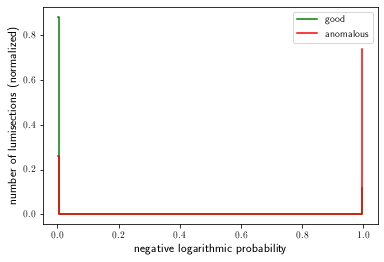

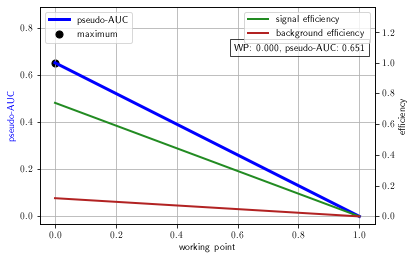

Accuracy: 0.8102226148301885
Precision: 0.8617190757749099
Recall: 0.7390396659707724
F-Measure: 0.7606991906036275


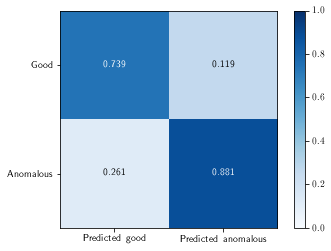

In [31]:
evaluate_autoencoders_combined(histstruct, mse_good_eval, mse_bad_eval, wpData)

In [32]:
def evaluate_autoencoders_combined_lp(logprob_good, logprob_bad, fmBiasFactor, wpBiasFactor):
    labels_good = np.zeros(len(logprob_good)) # background: label = 0
    labels_bad = np.ones(len(logprob_bad)) # signal: label = 1
    
    badMin = min(np.where(logprob_bad != -np.inf, logprob_bad, -1))
    goodMax = max(np.where(logprob_good != np.inf, logprob_good, 10001))
    
    logprob_good = np.where(logprob_good != np.inf, logprob_good, goodMax)
    logprob_bad = np.where(logprob_bad != -np.inf, logprob_bad, badMin)
    
    # These only take effect if a histogram is grossly misclassified
    logprob_good[logprob_good == -np.inf] = badMin
    logprob_bad[logprob_bad == np.inf] = goodMax
    
    labels = np.concatenate(tuple([labels_good,labels_bad]))
    scores = np.concatenate(tuple([-logprob_good,-logprob_bad]))
    scores = aeu.clip_scores( scores )
    
    avSep = np.mean(logprob_good) - np.mean(logprob_bad)
    
    print('Average Separation: ' + str(avSep))
    
    pu.plot_score_dist(scores, labels, siglabel='anomalous', sigcolor='r', 
                       bcklabel='good', bckcolor='g', 
                       nbins=200, normalize=True,
                       xaxtitle='negative logarithmic probability',
                       yaxtitle='number of lumisections (normalized)')
      
    # Plot ROC curve for analysis
    auc = aeu.get_roc(scores, labels, mode='geom', doprint=False)
    
    # Setting a threshold, below this working point defines anomalous data
    # Average is biased towards better recall per user specifications
    logprob_threshold = (1/(wpBiasFactor + 1)) * (wpBiasFactor*np.mean(logprob_good) + np.mean(logprob_bad))
    # Or set manual
    # logprob_threshold = 100
    (_, _, _, tp, fp, tn, fn) = aeu.get_confusion_matrix(scores,labels,-logprob_threshold)
    print('Selected logprob threshold of ' + str(logprob_threshold))
    
    # Get metrics for analysis
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_measure = (1 + fmBiasFactor * fmBiasFactor) * ((precision * recall) / ((fmBiasFactor * fmBiasFactor * precision) + recall)) 
    
    print('Accuracy: ' + str(accuracy))
    print('Precision: ' + str(precision))
    print('Recall: ' + str(recall))
    print('F-Measure: ' + str(f_measure))
    
    return logprob_threshold